<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/CP%20CPMG%20UDD%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 32.6 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


#6. Pulse Shaping

### 1) Single $ \pi $ Envelope

In [3]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

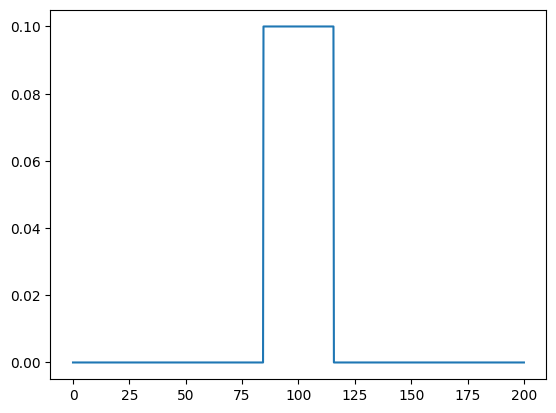

In [4]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Square(tlist, {'A': 0.1}, 100))

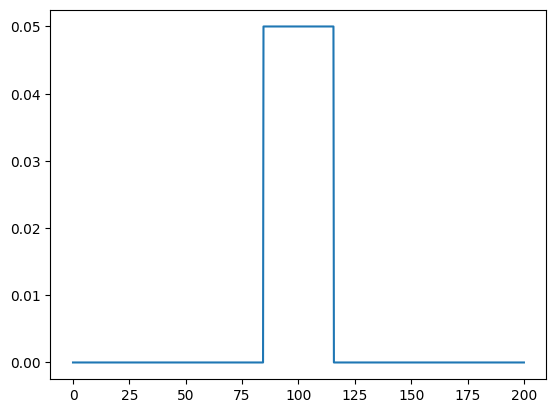

In [5]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Square(tlist, {'A': 0.1}, 100))

In [6]:
# single pi & half pi cosine pulse for drive

def Pi_Cosine(t, args, T_cent):

    A = args['A']

    return (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Cosine(t, args, T_cent):

    A = args['A']

    return 0.5 * (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

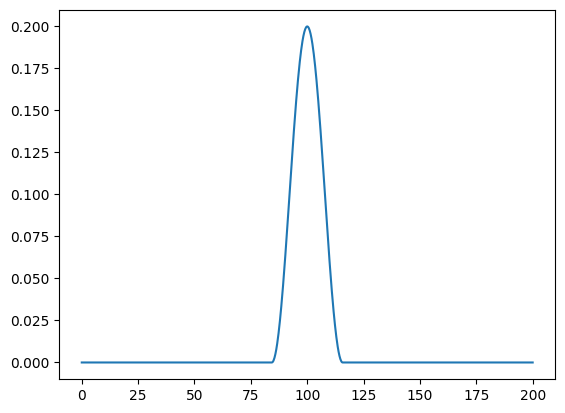

In [7]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Cosine(tlist, {'A': 0.1}, 100))

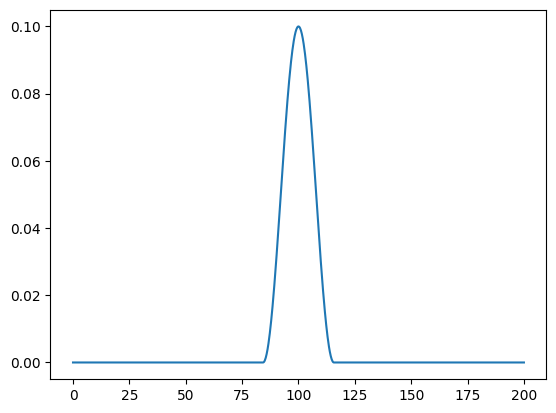

In [8]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Cosine(tlist, {'A': 0.1}, 100))

In [9]:
# single pi & half pi gaussian pulse for drive

def Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return A * np.exp(-A**2*(t-T_cent)**2/np.pi)

def Half_Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return 0.5 * A * np.exp(-A**2*(t-T_cent)**2/np.pi)

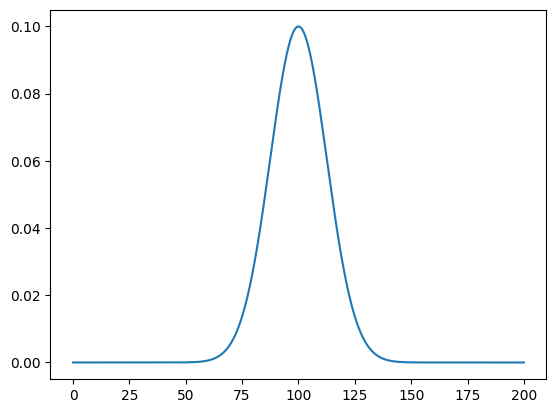

In [10]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Gaussian(tlist, {'A': 0.1}, 100))

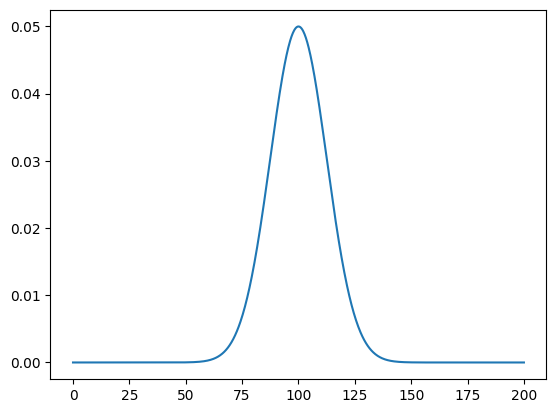

In [11]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Gaussian(tlist, {'A': 0.1}, 100))

### 2) Single $ \pi $ Pulse

In [12]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

  elif (Env==1 and Is_Pi==0):
    return Half_Pi_Cosine

  elif (Env==1 and Is_Pi==1):
    return Pi_Cosine

  elif (Env==2 and Is_Pi==0):
    return Half_Pi_Gaussian

  elif (Env==2 and Is_Pi==1):
    return Pi_Gaussian

In [13]:
# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

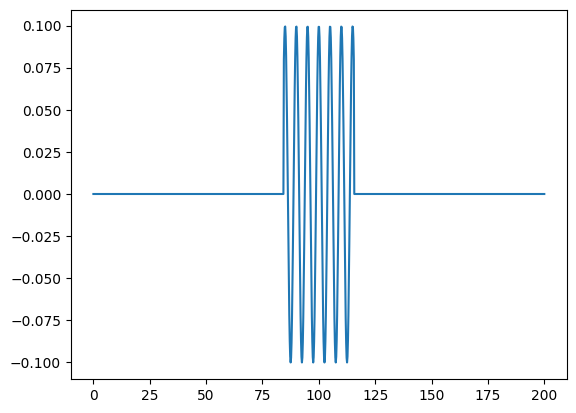

In [14]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(0, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.2, 'Phi': 0}, 100))

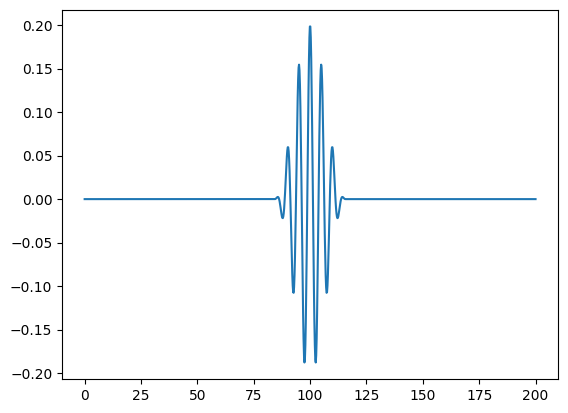

In [15]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(1, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.2, 'Phi': 0}, 100))

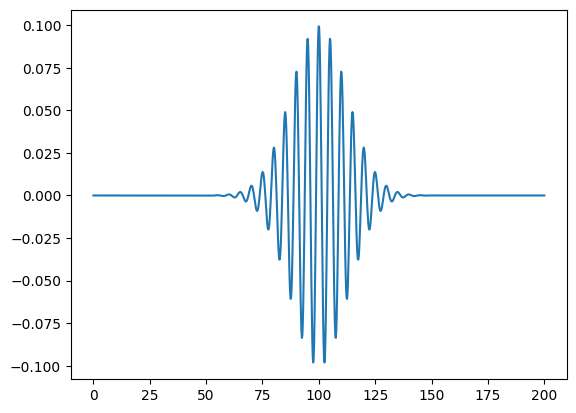

In [16]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(2, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.2, 'Phi': 0}, 100))

### 3) Pulse Shaping Function

In [17]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [18]:
Pulse_Timing(0, 200, 10, 0)

array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190.])

In [19]:
Pulse_Timing(100, 300, 10, 2)

array([106.81483474, 119.9800845 , 138.59855926, 161.40144074,
       186.83475024, 213.16524976, 238.59855926, 261.40144074,
       280.0199155 , 293.18516526])

In [20]:
# time-dependent envelope for drive (lab frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_lab_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    # CP
    if (Func==0) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)

    # CPMG & UDD
    else :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    return pulse

In [21]:
# time-dependent envelope for drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': A}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': A}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': A}, T_end)

    return pulse

### 4) Visualize Ramsey & Spin Echo Pulse (Lab Frame)

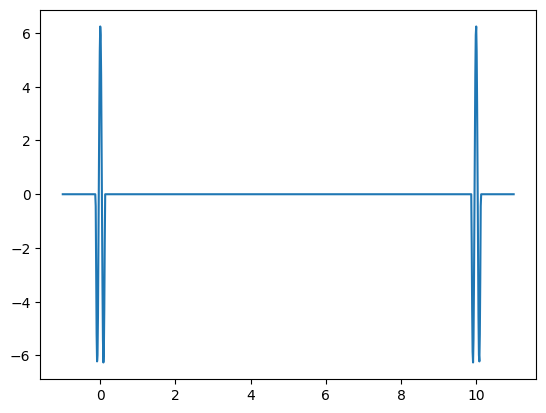

In [22]:
# Ramsey
# Square Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 0, 'Func': 0}))

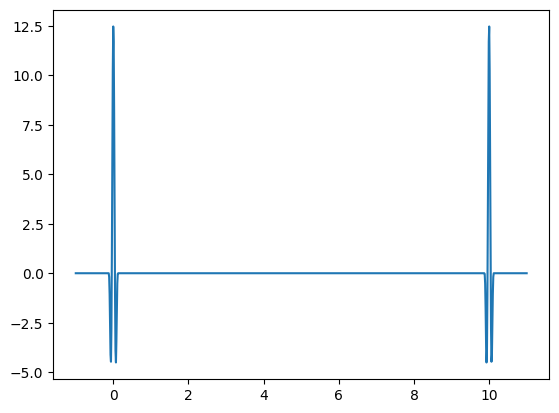

In [23]:
# Ramsey
# Cosine Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 1, 'Func': 0}))

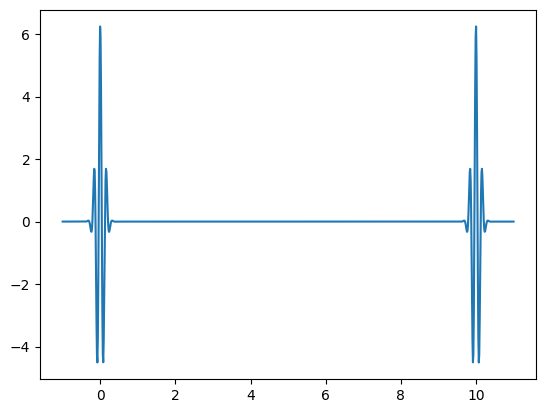

In [24]:
# Ramsey
# Gaussian Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 2, 'Func': 0}))

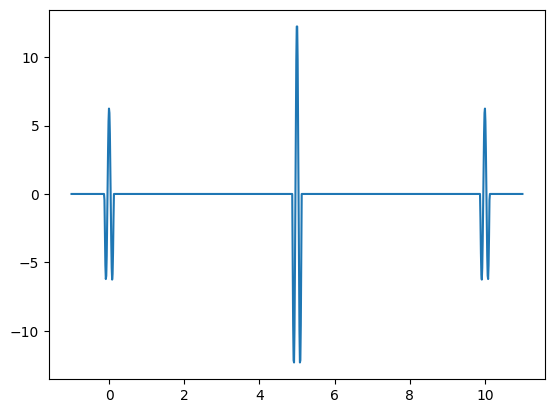

In [25]:
# Spin Echo
# Square Pulse
# X Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 0}))

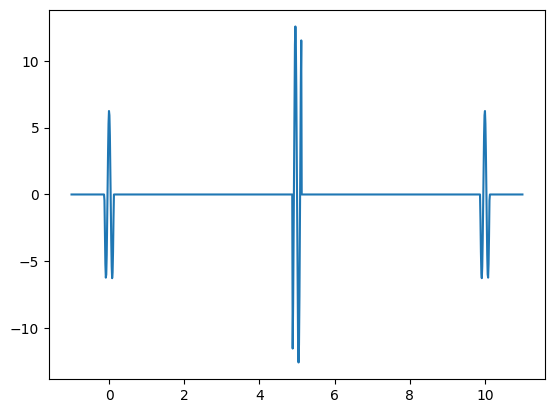

In [26]:
# Spin Echo
# Square Pulse
# Y Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 1}))

### 5) Visualize CP Pulse (Lab Frame)

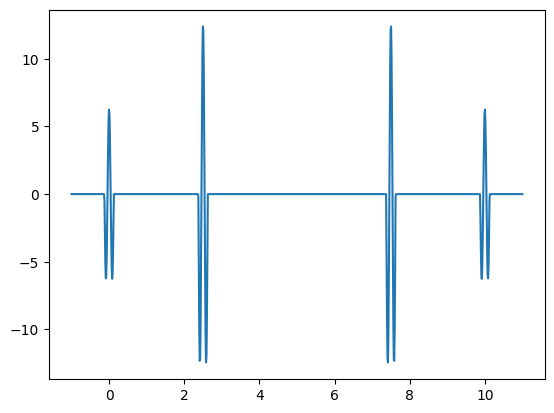

In [27]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 0}))

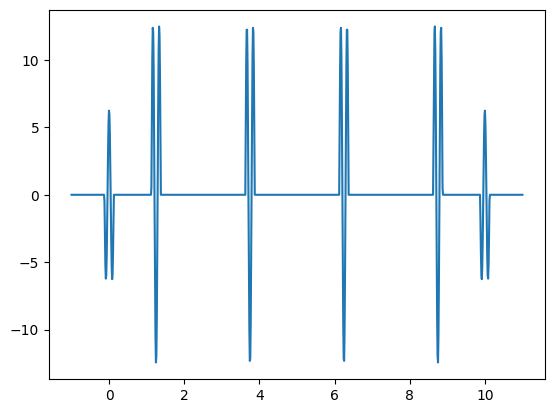

In [28]:
# CP
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 0}))

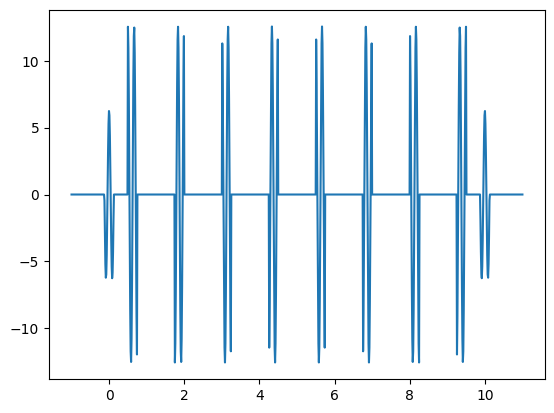

In [29]:
# CP
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 0}))

### 6) Visualize CPMG Pulse (Lab Frame)

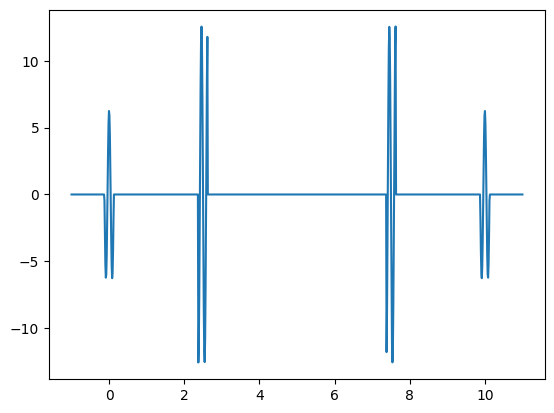

In [30]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 1}))

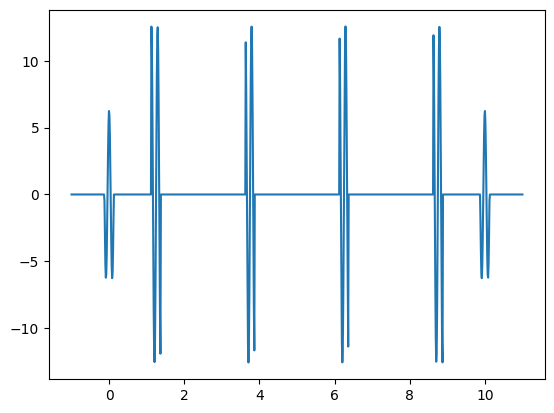

In [31]:
# CPMG
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 1}))

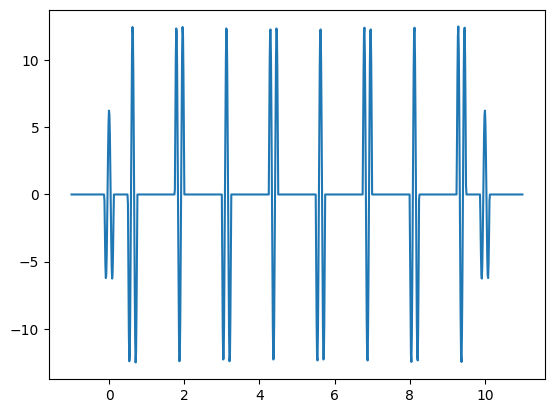

In [32]:
# CPMG
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 1}))

### 7) Visualize UDD Pulse (Lab Frame)

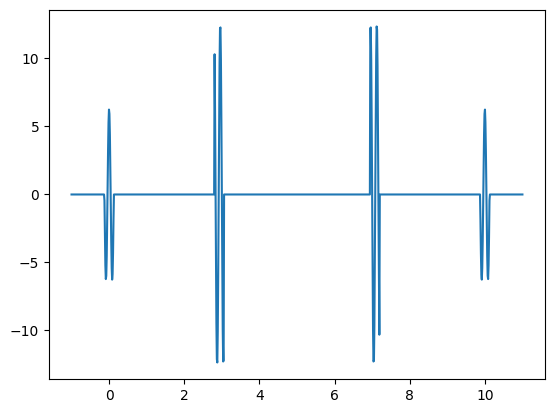

In [33]:
# UDD
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 2}))

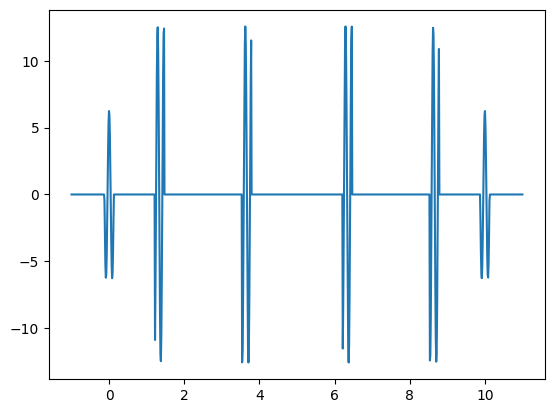

In [34]:
# UDD
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 2}))

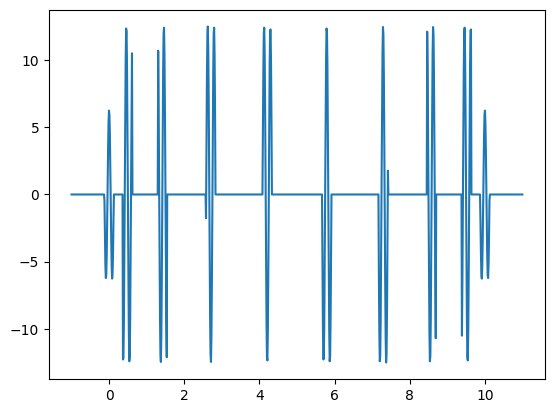

In [35]:
# UDD
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 2}))

### 8) Visualize Ramsey & Spin Echo Pulse (Rotating Frame)

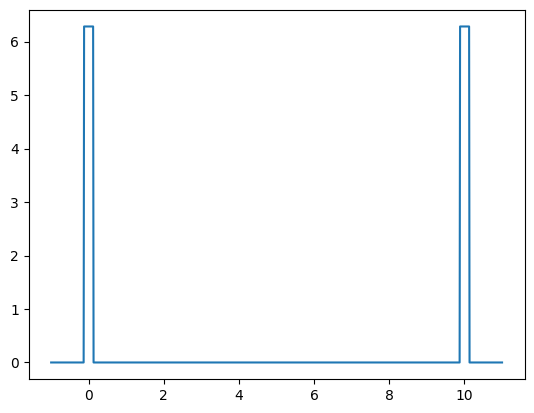

In [36]:
# Ramsey
# Square Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 0, 'Func': 0}))

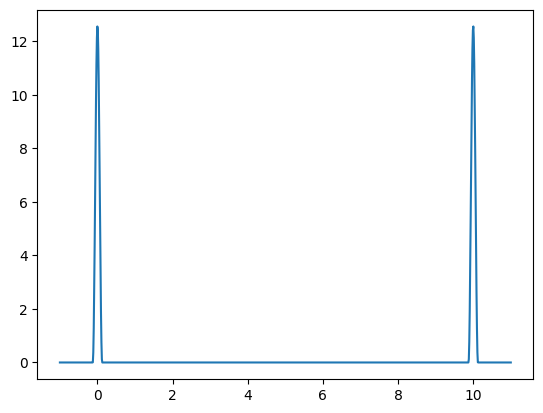

In [37]:
# Ramsey
# Cosine Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 1, 'Func': 0}))

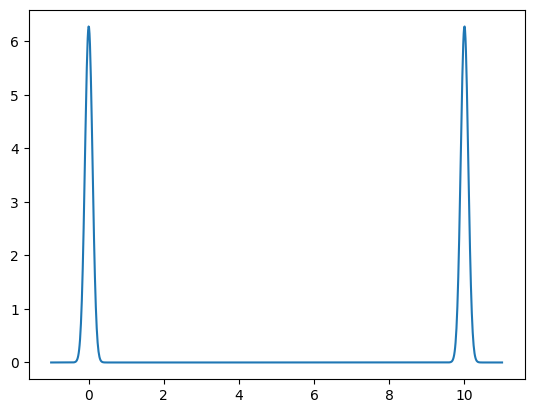

In [38]:
# Ramsey
# Gaussian Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 2, 'Func': 0}))

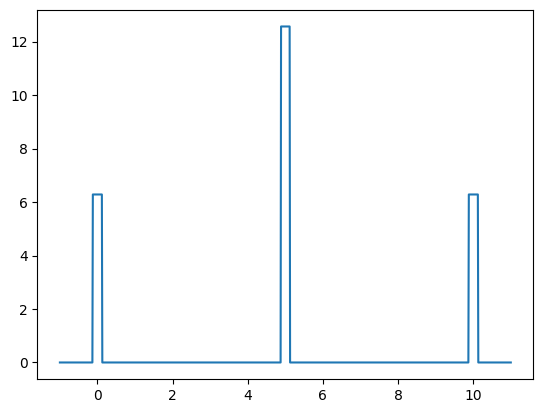

In [39]:
# Spin Echo
# Square Pulse
# X Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 0}))

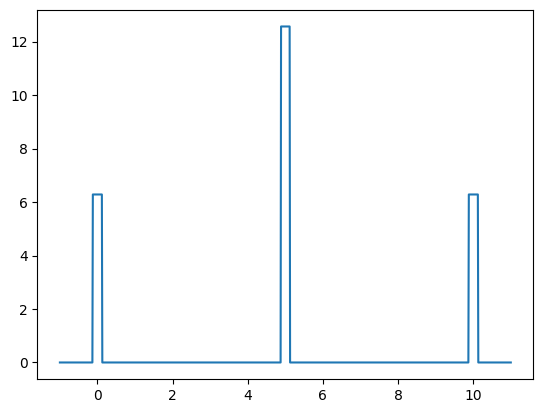

In [40]:
# Spin Echo
# Square Pulse
# Y Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 1}))

### 9) Visualize CP Pulse (Rotating Frame)

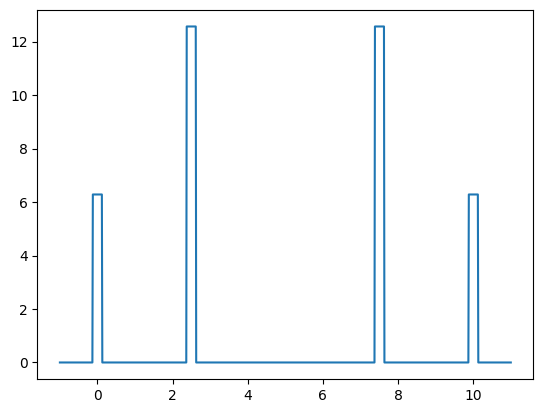

In [41]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 0}))

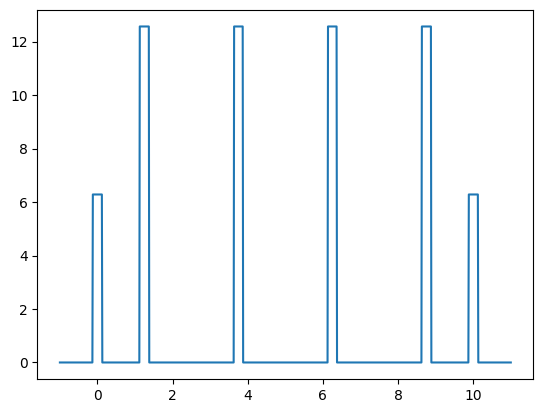

In [42]:
# CP
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 0}))

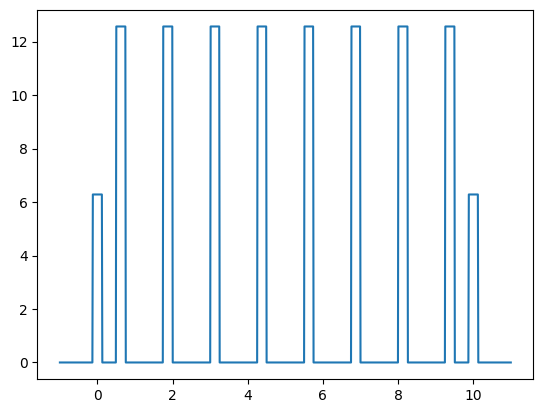

In [43]:
# CP
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 0}))

### 10) Visualize CPMG Pulse (Rotating Frame)

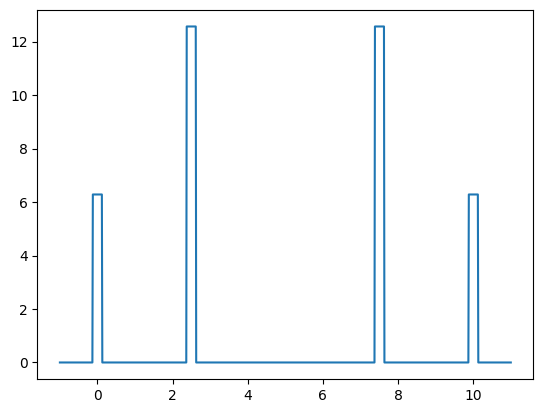

In [44]:
# CPMG
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 1}))

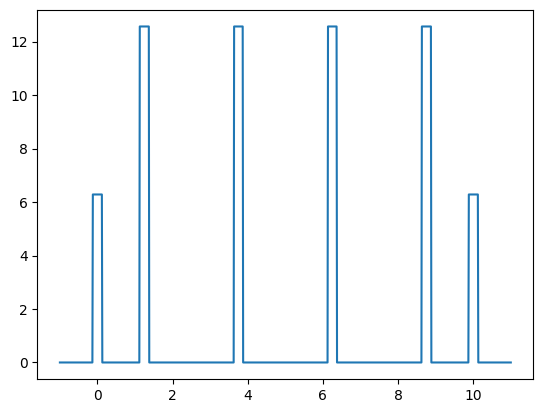

In [45]:
# CPMG
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 1}))

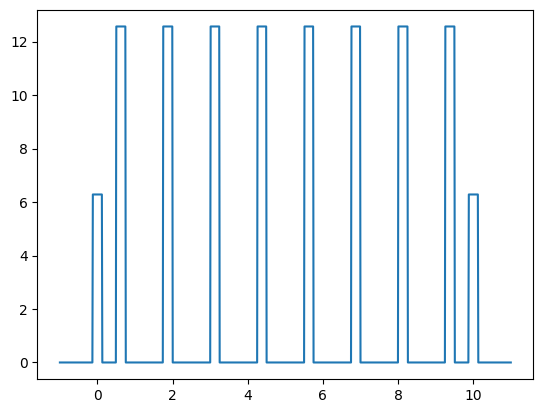

In [46]:
# CPMG
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 1}))

### 11) Visualize UDD Pulse (Rotating Frame)

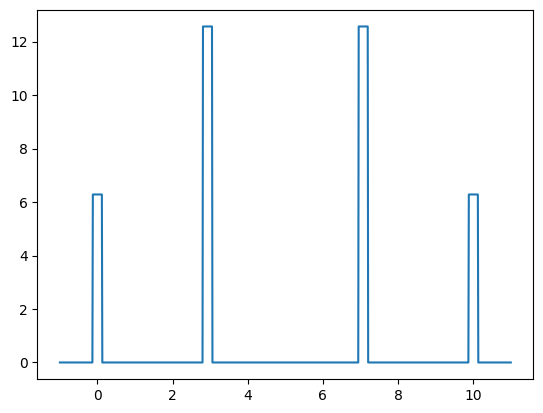

In [47]:
# UDD
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 2}))

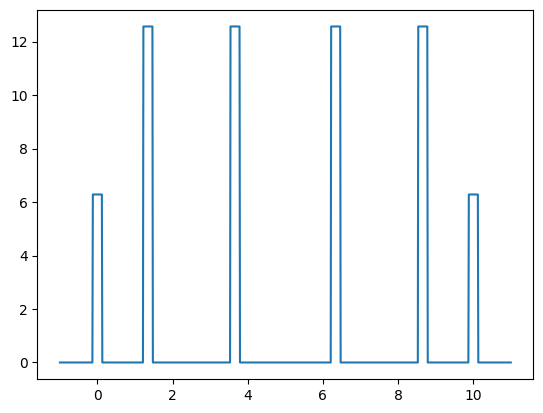

In [48]:
# UDD
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 2}))

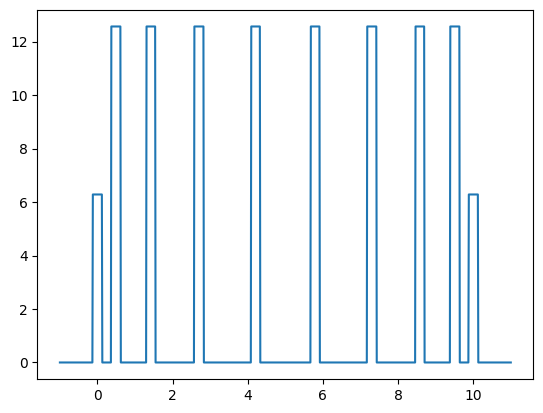

In [49]:
# UDD
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 2}))

### 12) Qubit not coupled with Resonator (Lab Frame)

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

In [50]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rd = 2 * np.pi * 6.0  # qubit frequency in units of GHz

In [51]:
# operator

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]

### 13) Ramsey : Varying Amplitude

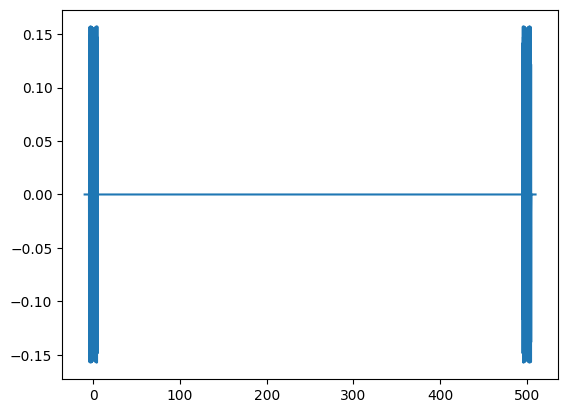

In [52]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.05

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [53]:
tlist = np.linspace(-10,510,100000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

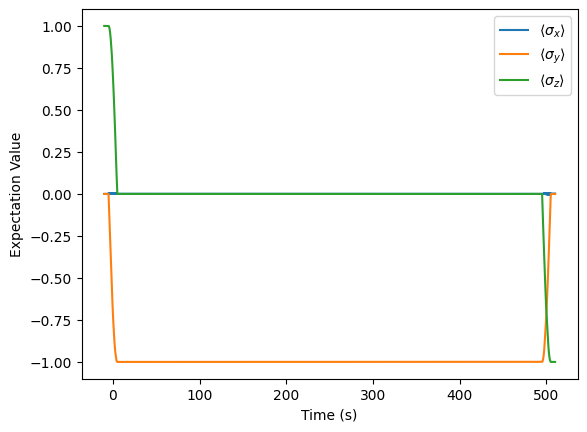

In [54]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result0.expect[0])*np.cos(omega_rd*tlist)-(result0.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result0.expect[1])*np.cos(omega_rd*tlist)+(result0.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

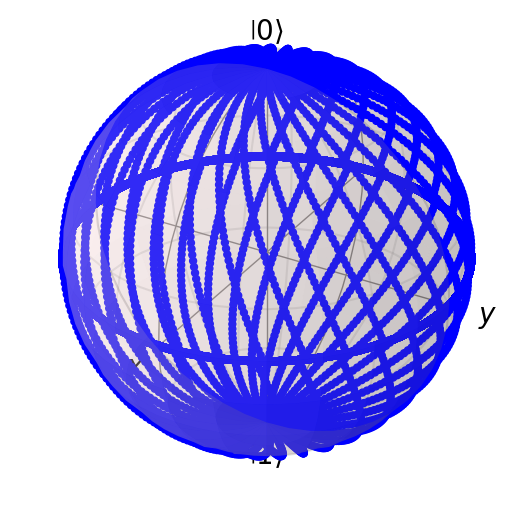

In [55]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

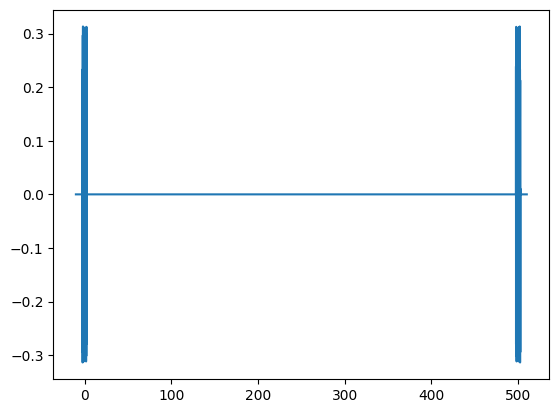

In [56]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.1

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [57]:
tlist = np.linspace(-10,510,100000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

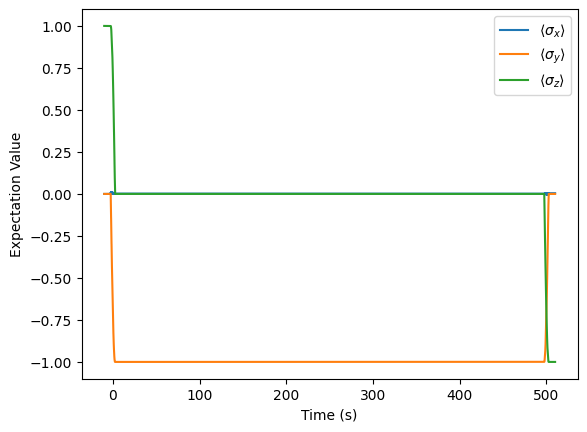

In [58]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result0.expect[0])*np.cos(omega_rd*tlist)-(result0.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result0.expect[1])*np.cos(omega_rd*tlist)+(result0.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

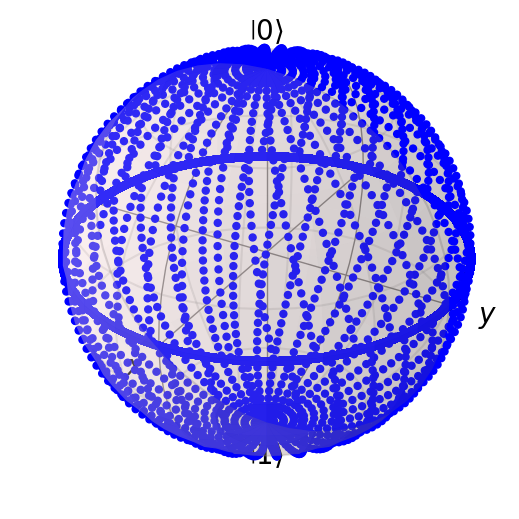

In [59]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

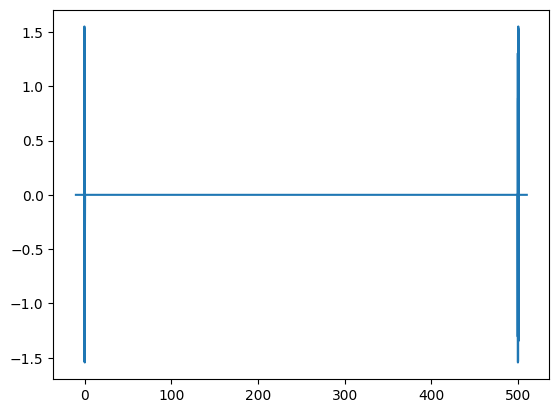

In [60]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.5

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.5, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [61]:
tlist = np.linspace(-10,510,100000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.5, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

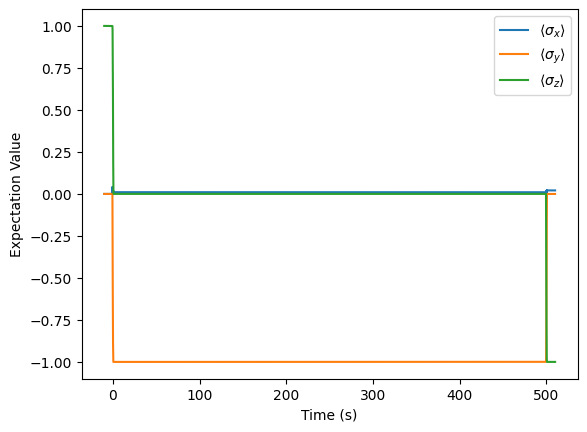

In [62]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result0.expect[0])*np.cos(omega_rd*tlist)-(result0.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result0.expect[1])*np.cos(omega_rd*tlist)+(result0.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

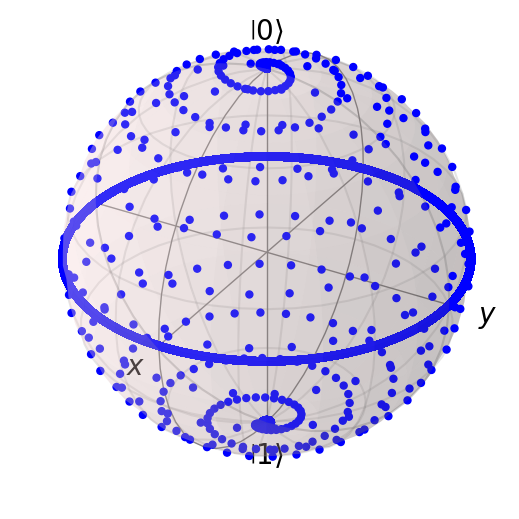

In [63]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

### 14) Ramsey, Spin Echo, CP (N=2)

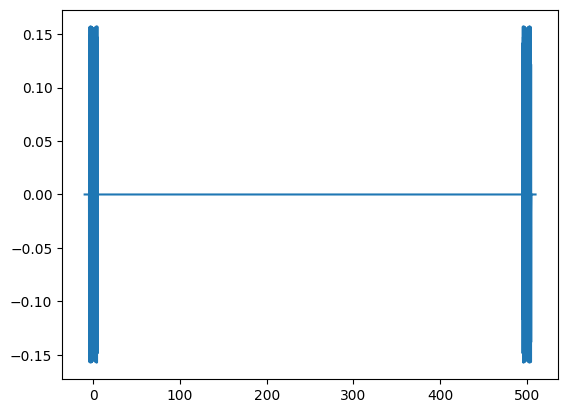

In [64]:
# Square Pulse
# 'A': 2*np.pi*0.05
# Ramsey

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [65]:
tlist = np.linspace(-10,510,100000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

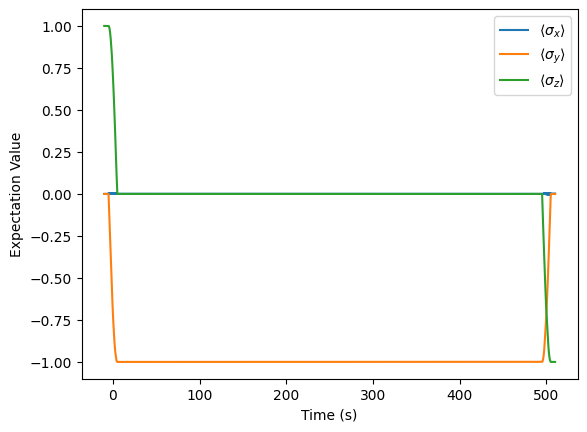

In [66]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result0.expect[0])*np.cos(omega_rd*tlist)-(result0.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result0.expect[1])*np.cos(omega_rd*tlist)+(result0.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

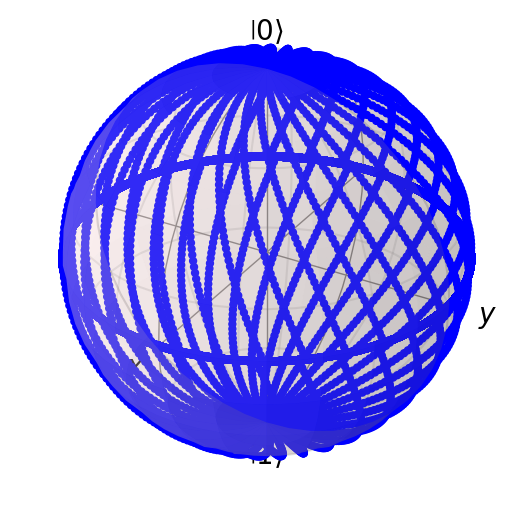

In [67]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

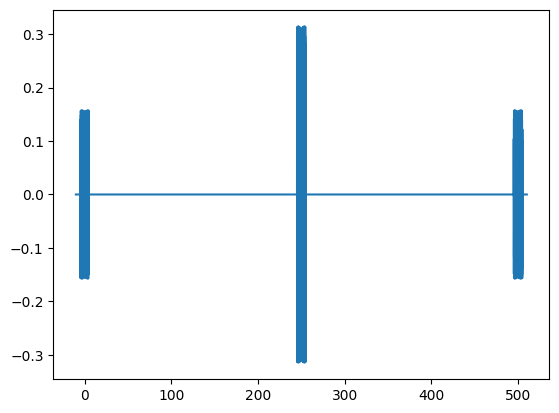

In [68]:
# Square Pulse
# 'A': 2*np.pi*0.05
# Spin Echo

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 1, 'Env': 0, 'Func': 0}))

In [69]:
tlist = np.linspace(-10,510,100000)

result1 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 1, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

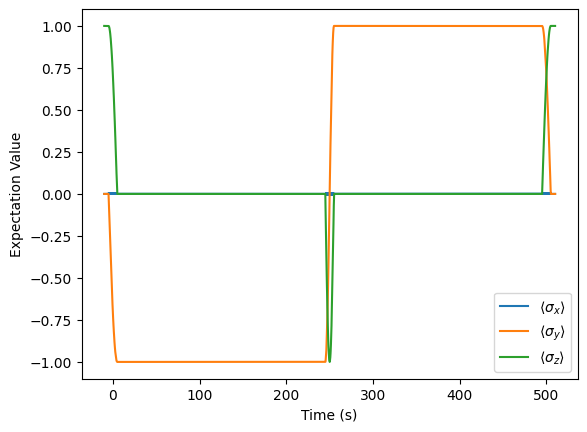

In [70]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result1.expect[0])*np.cos(omega_rd*tlist)-(result1.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result1.expect[1])*np.cos(omega_rd*tlist)+(result1.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result1.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

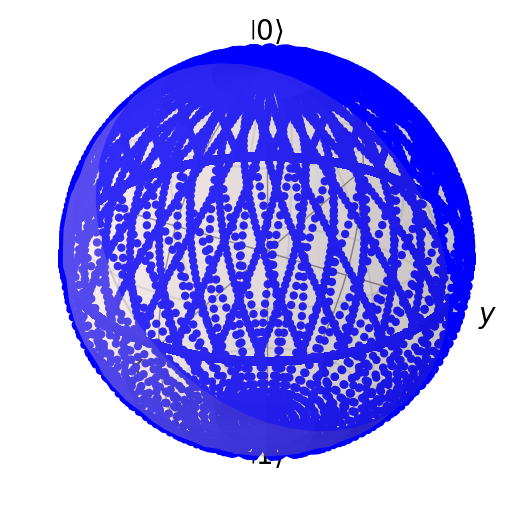

In [71]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result1.expect, meth="s")
sphere.show()

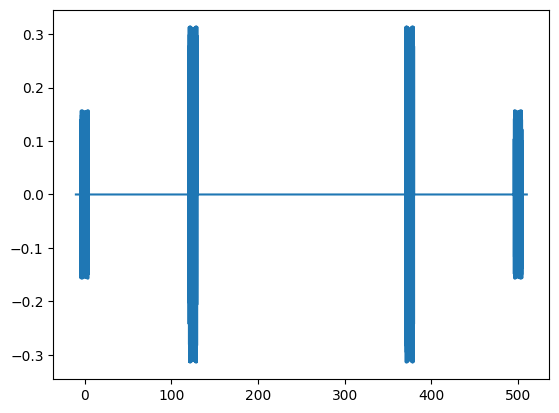

In [72]:
# Square Pulse
# 'A': 2*np.pi*0.05
# CP (N=2)

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 2, 'Env': 0, 'Func': 0}))

In [73]:
tlist = np.linspace(-10,510,100000)

resultCP2 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 2, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

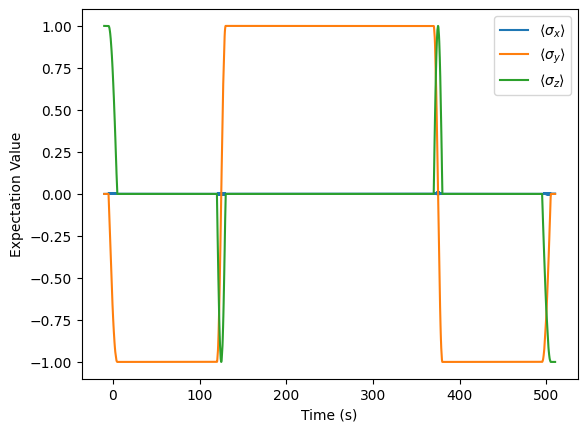

In [74]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (resultCP2.expect[0])*np.cos(omega_rd*tlist)-(resultCP2.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (resultCP2.expect[1])*np.cos(omega_rd*tlist)+(resultCP2.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, resultCP2.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

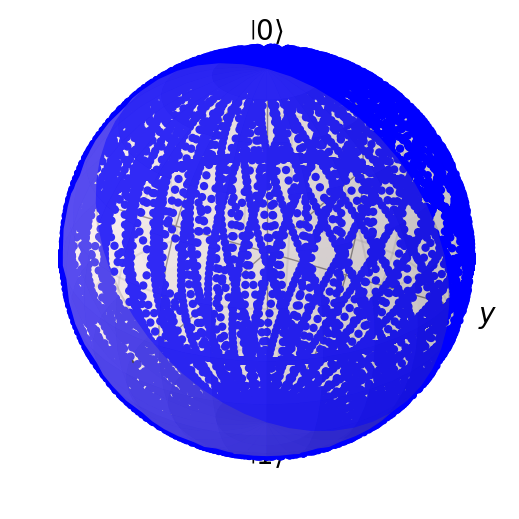

In [75]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(resultCP2.expect, meth="s")
sphere.show()

# 7. Bloch - Redfield Approach Decoupling?

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

$L = \sqrt{\frac{\Gamma_\phi}{2}}\sigma_z $

### 1) T2 Measuring Function

In [76]:
def T2_Measure(A, N, Func):

  omega_q = 2 * np.pi * 6.0
  omega_rd = 2 * np.pi * 6.0
  gamma_phi = 2 * np.pi * 0.0001

  sz = sigmaz()
  sx = sigmax()
  sy = sigmay()

  H0 = -0.5*omega_q*sz

  op_list = [sx, sy, sz]
  col_list = [np.sqrt(gamma_phi/2) * sz]


  T_end_seq = [10*i for i in range(20,101,5)]
  Off_diagonal_seq = []


  for i in range(20,101,5):

    tlist = np.linspace(-6, 10*i+10*N-6, 10000)

    result = mesolve(
      [H0, [sx, Hrd_lab_frame]],
      basis(2,0),
      tlist,
      c_ops = col_list,
      args = {'A': A, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*N, 'N': N, 'Env': 0, 'Func': Func},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    X = result.expect[0]
    Y = result.expect[1]
    Off_diagonal_seq.append(np.sqrt(X[-1]**2 + Y[-1]**2))


  return np.array(Off_diagonal_seq)

In [77]:
def func(t, C, T2):
    return C * np.exp(-t/T2)

### 2) CP Visualization

In [78]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rd = 2 * np.pi * 6.0  # qubit frequency in units of GHz

gamma_phi = 2 * np.pi * 0.0001

In [79]:
# operator

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]
col_list = [np.sqrt(gamma_phi/2) * sz]

In [80]:
# N=0

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

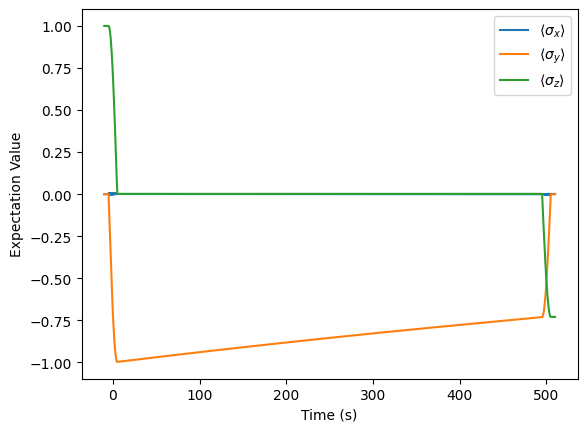

In [81]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result0.expect[0])*np.cos(omega_rd*tlist)-(result0.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result0.expect[1])*np.cos(omega_rd*tlist)+(result0.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

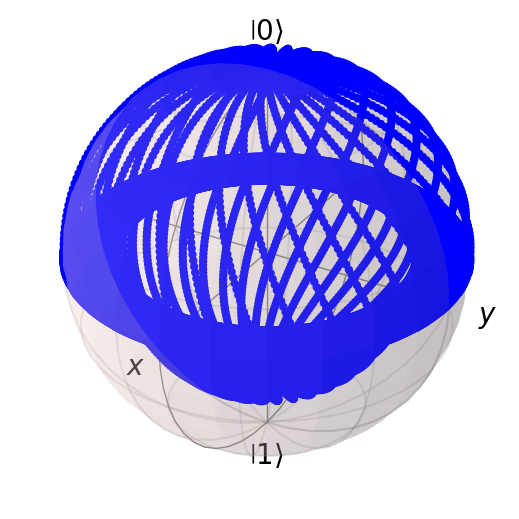

In [82]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

In [83]:
# N=1

result1 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 1, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

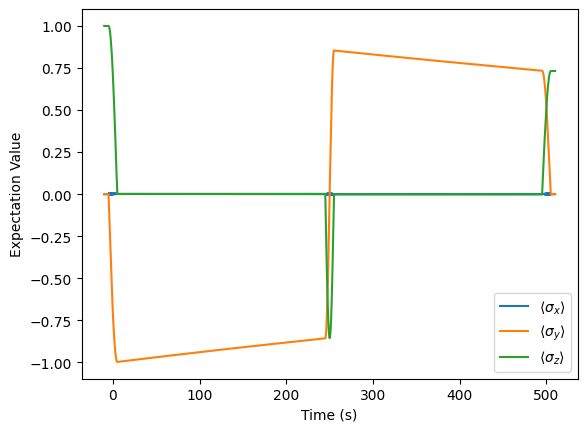

In [84]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result1.expect[0])*np.cos(omega_rd*tlist)-(result1.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result1.expect[1])*np.cos(omega_rd*tlist)+(result1.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result1.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

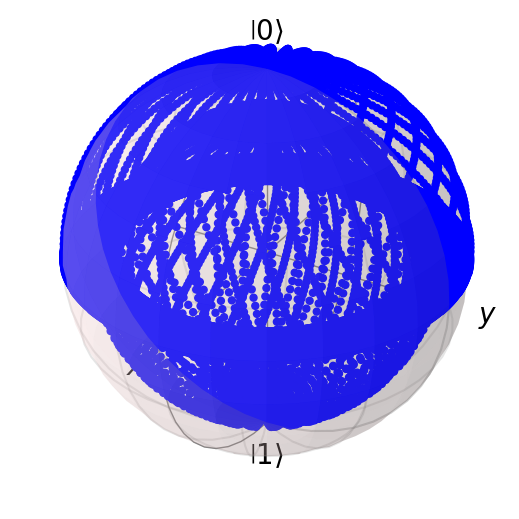

In [85]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result1.expect, meth="s")
sphere.show()

In [86]:
# N=2

result2 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 2, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

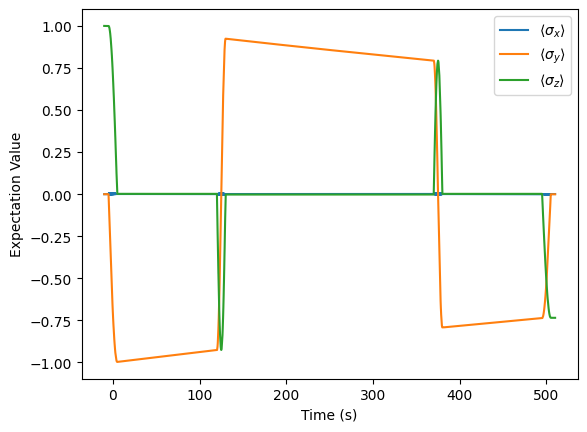

In [87]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result2.expect[0])*np.cos(omega_rd*tlist)-(result2.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result2.expect[1])*np.cos(omega_rd*tlist)+(result2.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result2.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

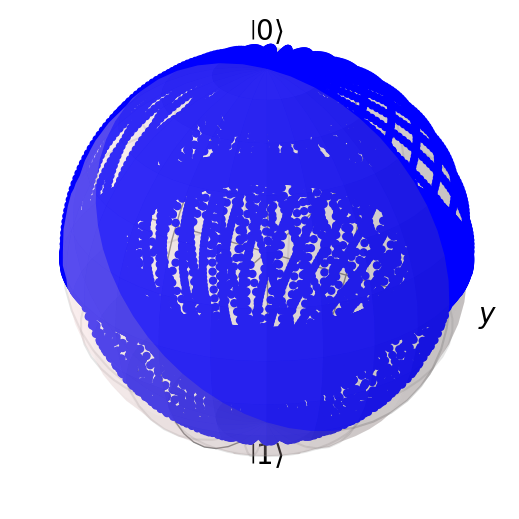

In [88]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result2.expect, meth="s")
sphere.show()

In [89]:
# N=4

result4 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 4, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

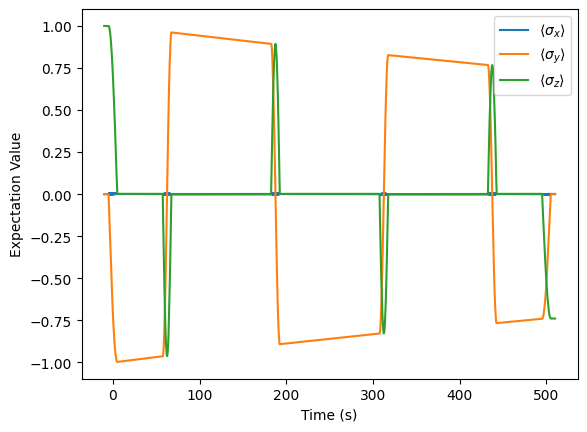

In [90]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result4.expect[0])*np.cos(omega_rd*tlist)-(result4.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result4.expect[1])*np.cos(omega_rd*tlist)+(result4.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result4.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

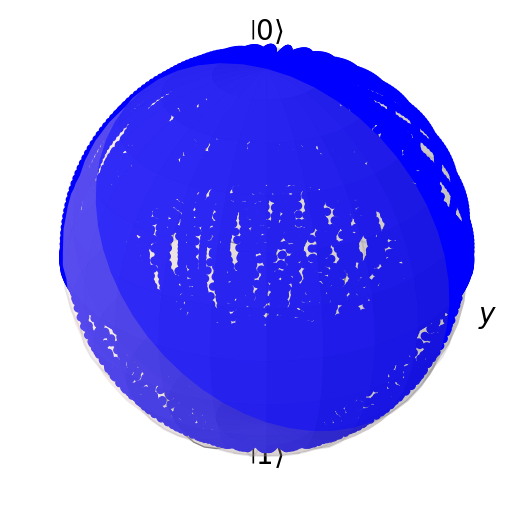

In [91]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result4.expect, meth="s")
sphere.show()

### 3) CPMG Visualization

In [92]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rd = 2 * np.pi * 6.0  # qubit frequency in units of GHz

gamma_phi = 2 * np.pi * 0.0001

In [93]:
# operator

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]
col_list = [np.sqrt(gamma_phi/2) * sz]

In [94]:
# N=0

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 1},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

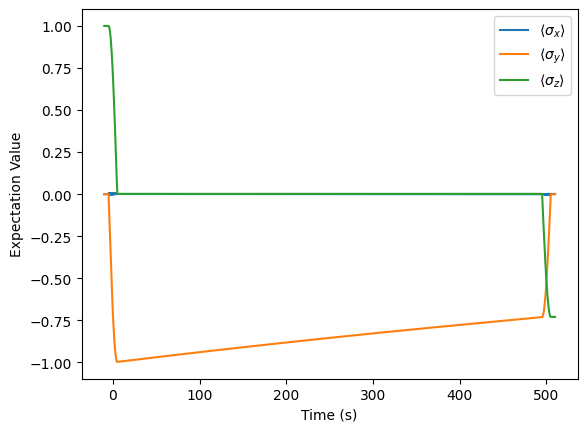

In [95]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result0.expect[0])*np.cos(omega_rd*tlist)-(result0.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result0.expect[1])*np.cos(omega_rd*tlist)+(result0.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

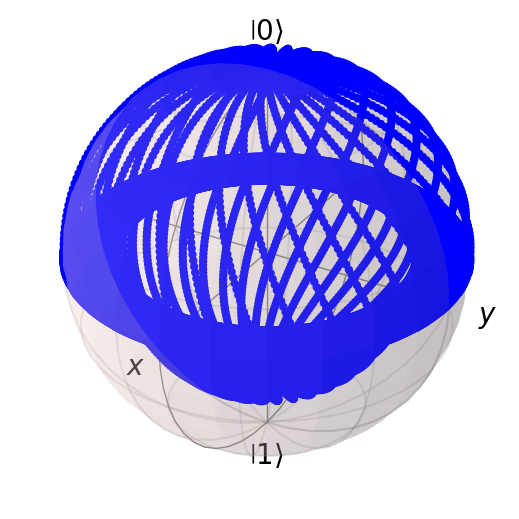

In [96]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

In [97]:
# N=1

result1 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 1, 'Env': 0, 'Func': 1},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

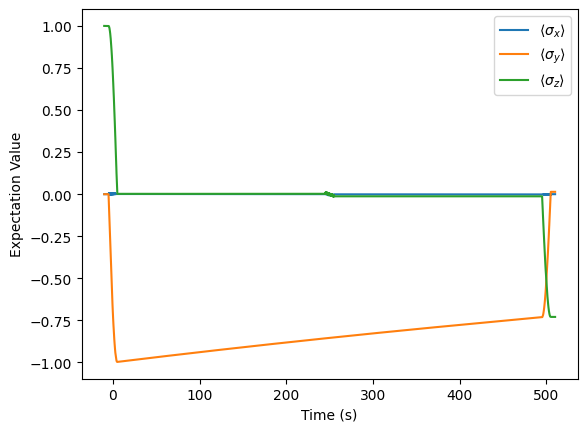

In [98]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result1.expect[0])*np.cos(omega_rd*tlist)-(result1.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result1.expect[1])*np.cos(omega_rd*tlist)+(result1.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result1.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

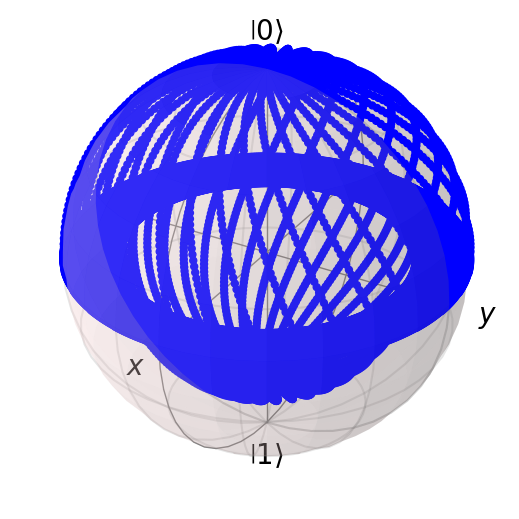

In [99]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result1.expect, meth="s")
sphere.show()

In [100]:
# N=2

result2 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 2, 'Env': 0, 'Func': 1},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

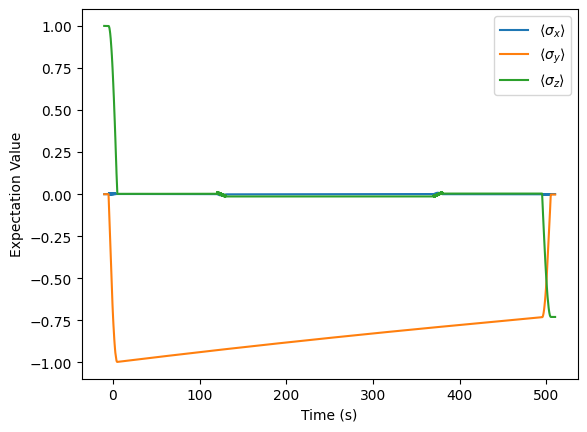

In [101]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result2.expect[0])*np.cos(omega_rd*tlist)-(result2.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result2.expect[1])*np.cos(omega_rd*tlist)+(result2.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result2.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

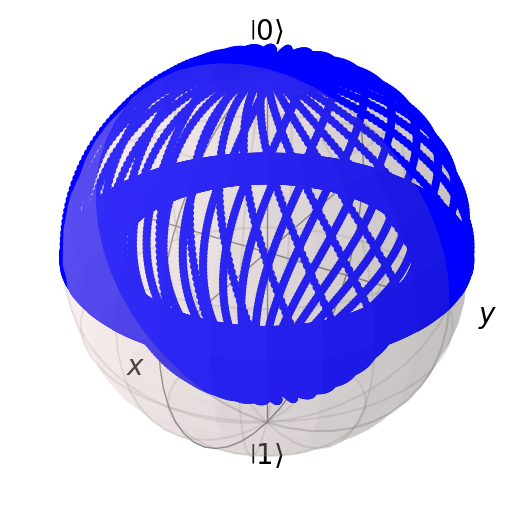

In [102]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result2.expect, meth="s")
sphere.show()

In [103]:
# N=4

result4 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    c_ops = col_list,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 4, 'Env': 0, 'Func': 1},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

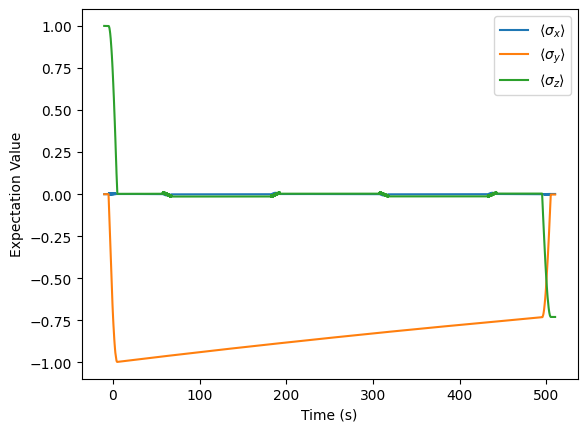

In [104]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, (result4.expect[0])*np.cos(omega_rd*tlist)-(result4.expect[1])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, (result4.expect[1])*np.cos(omega_rd*tlist)+(result4.expect[0])*np.sin(omega_rd*tlist), label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result4.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

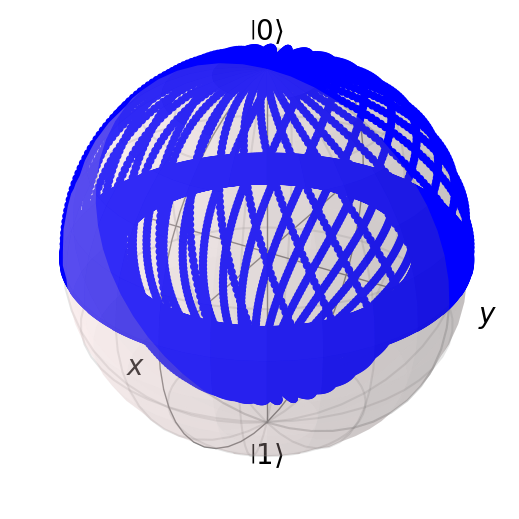

In [105]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result4.expect, meth="s")
sphere.show()

### 4) CP T2 Measure

In [106]:
# T2 according to N from 0 to 10
CP_T2_list = []

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

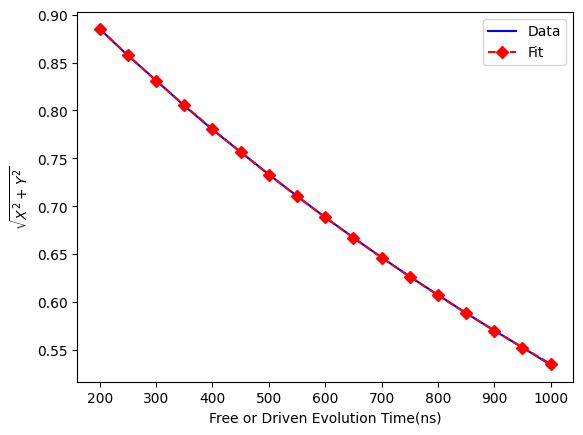

In [107]:
# N=0

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 0, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

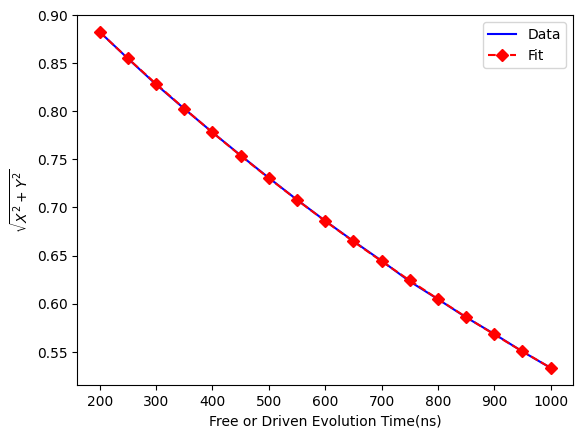

In [108]:
# N=1

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 1, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

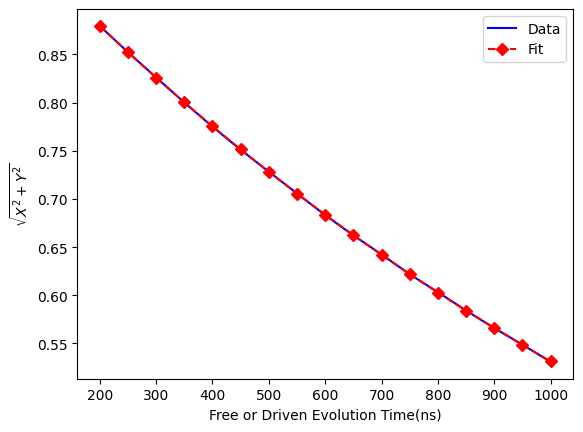

In [109]:
# N=2

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 2, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

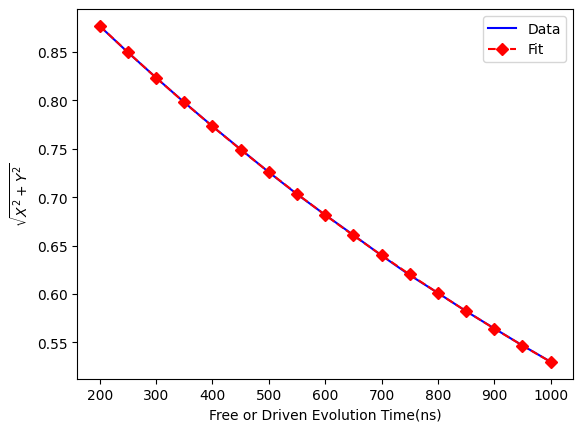

In [110]:
# N=3

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 3, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

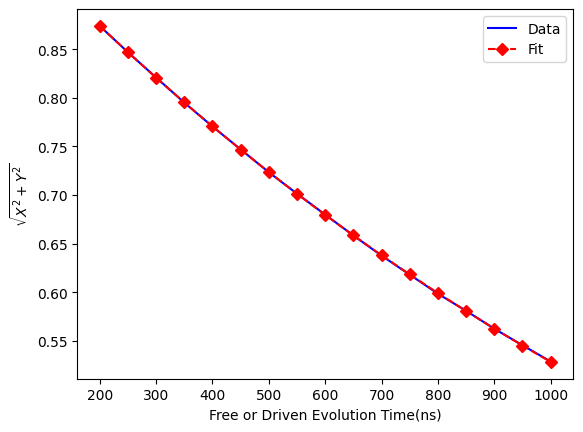

In [111]:
# N=4

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 4, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

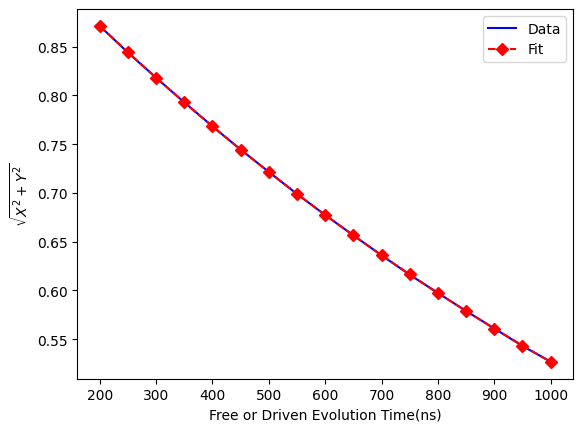

In [112]:
# N=5

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 5, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

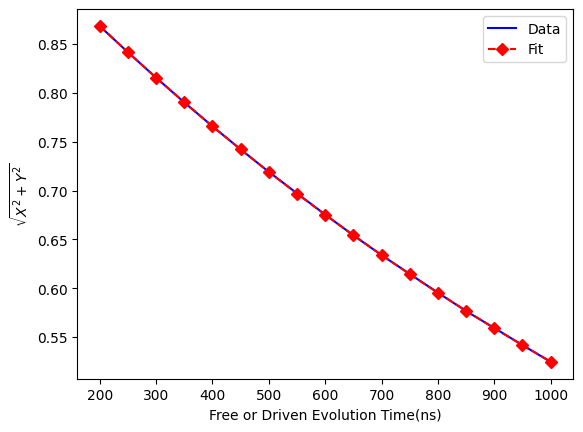

In [113]:
# N=6

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 6, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

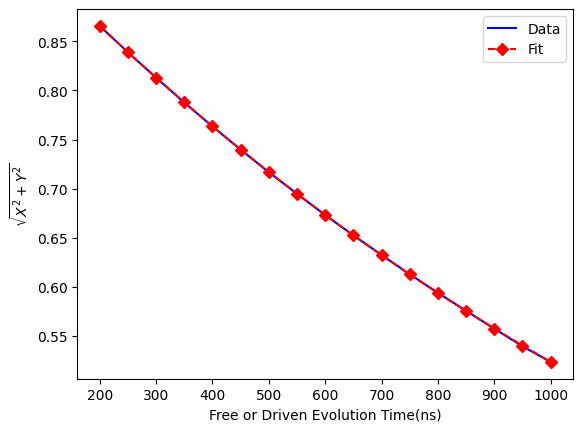

In [114]:
# N=7

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 7, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

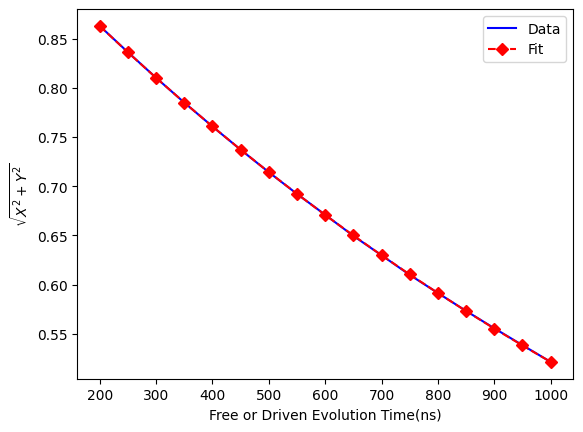

In [115]:
# N=8

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 8, 0)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CP_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

In [116]:
CP_T2_list

[1591.241684570809,
 1588.467286310774,
 1588.0099672846368,
 1587.7640559571278,
 1589.4836741234894,
 1589.2458801916919,
 1588.8893991631212,
 1588.9676680104528,
 1589.0574379019595]

### 5) CPMG T2 Measure

In [117]:
# T2 according to N from 0 to 10
CPMG_T2_list = []

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

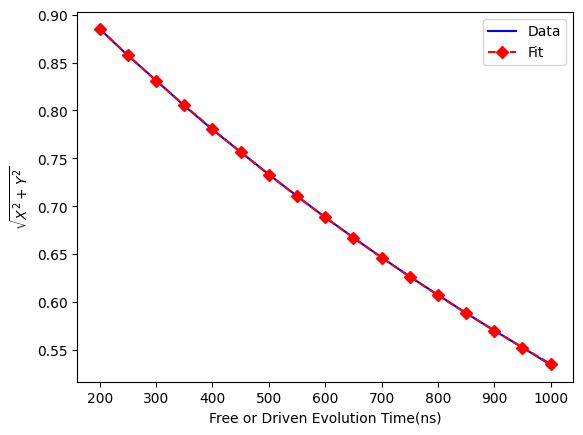

In [118]:
# N=0

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 0, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

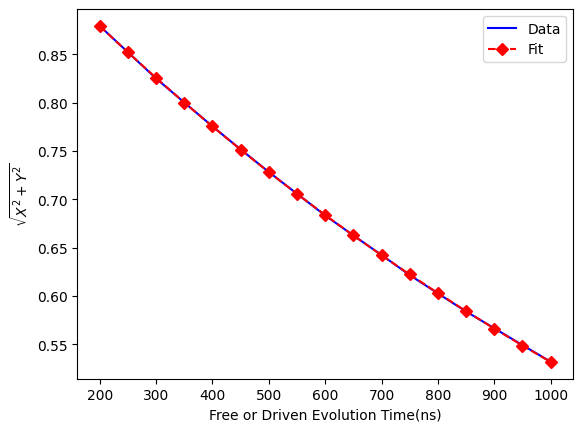

In [119]:
# N=1

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 1, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

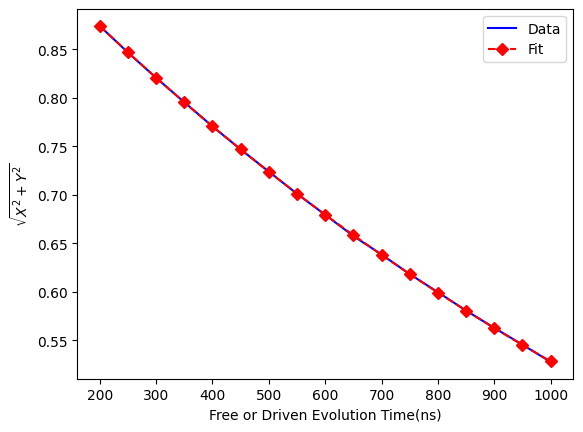

In [120]:
# N=2

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 2, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

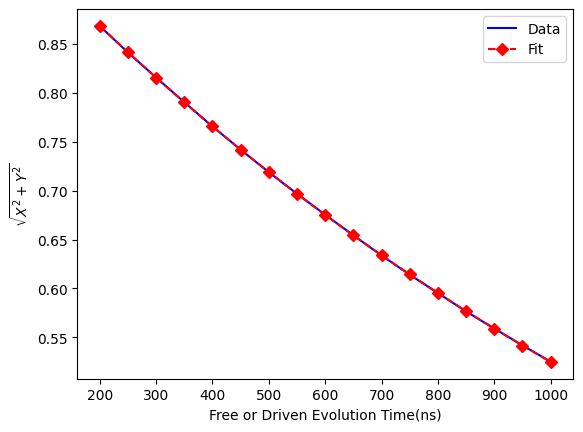

In [121]:
# N=3

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 3, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

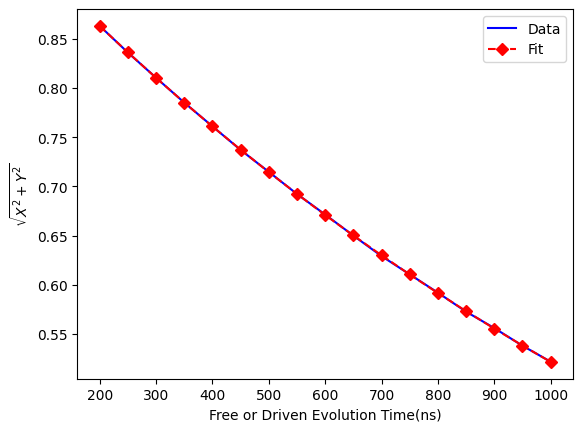

In [122]:
# N=4

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 4, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

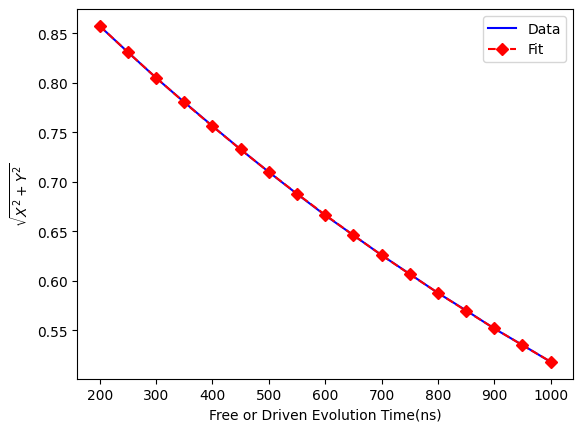

In [123]:
# N=5

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 5, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

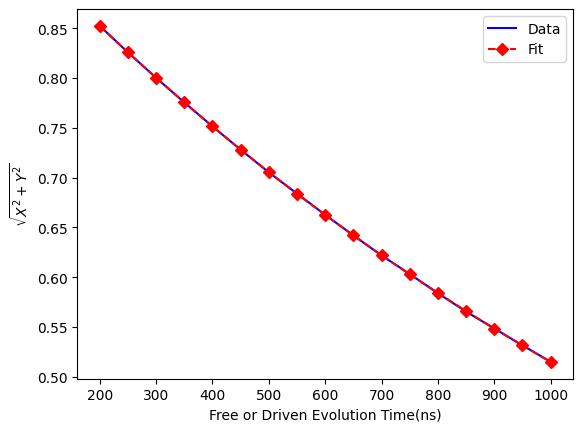

In [124]:
# N=6

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 6, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

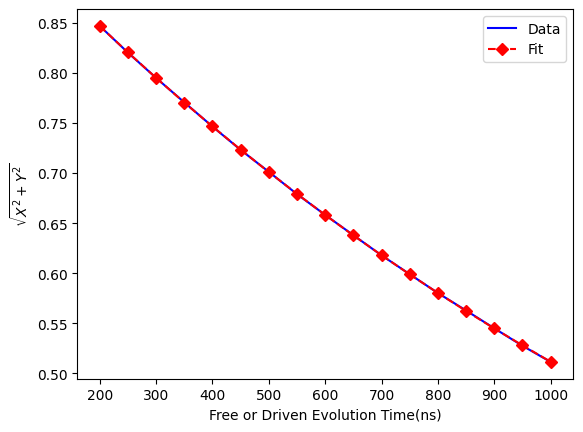

In [125]:
# N=7

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 7, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

Text(0, 0.5, '$\\sqrt{X^{2}+Y^{2}}$')

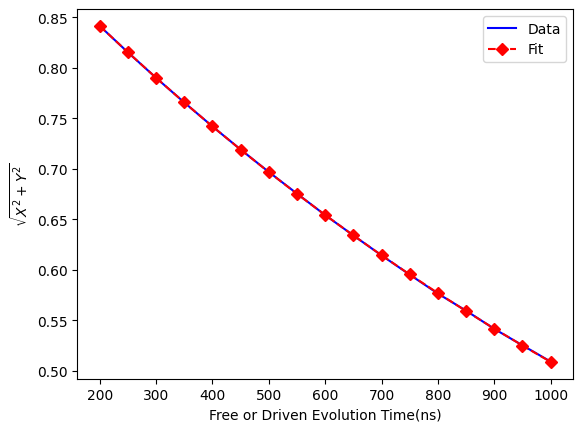

In [126]:
# N=8

Tau_list = np.array([10*i for i in range(20,101,5)])
Trans_list = T2_Measure(2*np.pi*0.05, 8, 1)

popt, pcov = curve_fit(func, Tau_list, Trans_list, p0 = [1, 10])
CPMG_T2_list.append(popt[1])

fig, ax = plt.subplots(1, 1)
ax.plot(Tau_list, Trans_list, label = 'Data', color='blue')
ax.plot(Tau_list, func(Tau_list, popt[0], popt[1]), 'rD--', label = 'Fit')
ax.legend()
ax.set_xlabel('Free or Driven Evolution Time(ns)')
ax.set_ylabel(r'$\sqrt{X^{2}+Y^{2}}$')

In [127]:
CPMG_T2_list

[1591.241684570809,
 1589.7646870126225,
 1588.8495385582733,
 1589.3321514393874,
 1589.046941673895,
 1588.4043539114266,
 1588.482386985545,
 1588.3479635552676,
 1589.652157998943]

# 8. Pink Noise Decoupling

$H = -\frac{\omega_q+\delta\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

### 1) Pink Noise (Chap 5 Repeated)

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [128]:
def Chi_Ensemble(mu, sigma, num_seq):

  np.random.seed(0)
  X = np.random.normal(mu, sigma, num_seq)

  np.random.seed(1)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [129]:
def Pink_Noise(tlist, args):

  min_freq = args['min_freq']
  freq_repeat = args['freq_repeat']
  mu = args['mu']
  sigma = args['sigma']
  A = args['A_noise']

  t_shift = args['t_shift']

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)

  np.random.seed(2)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  f = A * (Chi_A[0]/np.sqrt((0+1)*min_freq)) * np.sin(2*np.pi*(0+1)*min_freq*(tlist+t_shift)+U_A[0])

  for k in range(1, freq_repeat, 1):
    f = f + A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*(tlist+t_shift)+U_A[k])

  return f

In [130]:
def func(t, b, a):
    return b + a * t

In [131]:
min_freq = 0.00001
freq_repeat = 100000
t_shift = 0

t_repeat = 2000
t_srt = 0
t_end = 1000

mu = 0
sigma = 1

A = 1

args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise': 2*np.pi*0.000001}

0.006537529619562277


Text(0, 0.5, 'Pink_Noise Distribution')

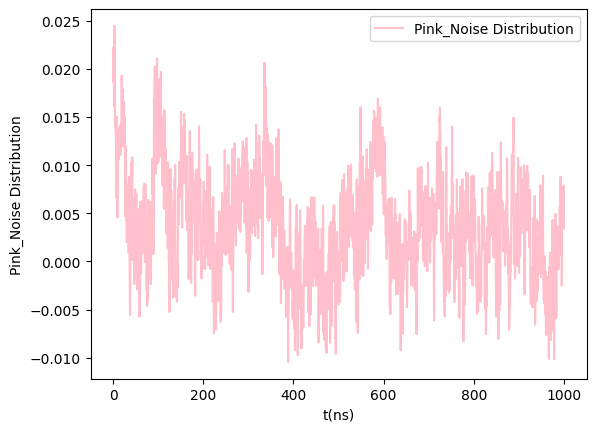

In [132]:
tlist = np.linspace(t_srt, t_end, t_repeat)
Pink_Noise_Sample = Pink_Noise(tlist, args)

print(np.sqrt(np.mean(Pink_Noise_Sample**2)))

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise_Sample, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(ns)')
ax.set_ylabel('Pink_Noise Distribution')

[-1.19551766 -0.51684922]


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:625: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'FT Absolute Value (log scale)')

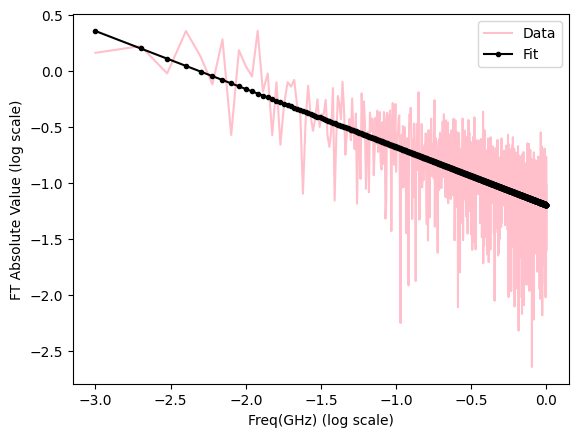

In [133]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

x_fft_plog = np.log10(x_fft[x_freq > 0])
x_freq_plog = np.log10(x_freq[x_freq > 0])

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])
print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(GHz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

### 2) Function Setting

In [134]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

# single pi & half pi cosine pulse for drive

def Pi_Cosine(t, args, T_cent):

    A = args['A']

    return (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Cosine(t, args, T_cent):

    A = args['A']

    return 0.5 * (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

# single pi & half pi gaussian pulse for drive

def Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return A * np.exp(-A**2*(t-T_cent)**2/np.pi)

def Half_Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return 0.5 * A * np.exp(-A**2*(t-T_cent)**2/np.pi)

In [135]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

  elif (Env==1 and Is_Pi==0):
    return Half_Pi_Cosine

  elif (Env==1 and Is_Pi==1):
    return Pi_Cosine

  elif (Env==2 and Is_Pi==0):
    return Half_Pi_Gaussian

  elif (Env==2 and Is_Pi==1):
    return Pi_Gaussian

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [136]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [137]:
# time-dependent envelope for drive (lab frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_lab_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    # CP
    if (Func==0) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)

    # CPMG & UDD
    else :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    return pulse

In [138]:
# time-dependent envelope for drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': A}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': A}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': A}, T_end)

    return pulse

In [139]:
def T2_Measure(A, N, Func, noise):

  omega_q = 2 * np.pi * 6.0 * 1000
  omega_rd = 2 * np.pi * 6.0 * 1000

  sz = sigmaz()
  sx = sigmax()
  sy = sigmay()

  H0 = -0.5*omega_q*sz

  op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]


  T_end_seq = [10*i+10*N for i in range(20,101,5)]
  Off_diagonal_seq = []


  for i in range(20,101,5):

    tlist = np.linspace(-6, 10*i+10*(N+1)-6, 10000)

    result = mesolve(
      [H0, [-0.5*sz, noise], [sx, Hrd_lab_frame]],
      basis(2,0),
      tlist,
      args = {'A': A, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*(N+1), 'N': N, 'Env': 0, 'Func': Func},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[0]
    minus = result.expect[1]
    Off_diagonal_seq.append(plus, minus)


  return np.array(Off_diagonal_seq)

### 3) Filtering Function (μs, MHz scale)

In [140]:
omega_list = np.linspace(0,10,10000)

def filter(omega_list, tau, N):

  if N==0:
    f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
    return f

  elif N==1:
    f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
    return f

  else:
    f = (4*np.sin(2*np.pi*tau*omega_list/(4*N))*np.sin(2*np.pi*tau*omega_list/2)*np.cos(3*2*np.pi*tau*omega_list/(4*N))/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2
    return f

<ipython-input-140-4b47b7f66497>:6: RuntimeWarning: invalid value encountered in divide
  f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
<ipython-input-140-4b47b7f66497>:10: RuntimeWarning: invalid value encountered in divide
  f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
<ipython-input-140-4b47b7f66497>:14: RuntimeWarning: invalid value encountered in divide
  f = (4*np.sin(2*np.pi*tau*omega_list/(4*N))*np.sin(2*np.pi*tau*omega_list/2)*np.cos(3*2*np.pi*tau*omega_list/(4*N))/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2


Text(0, 0.5, 'Filter Function Distribution')

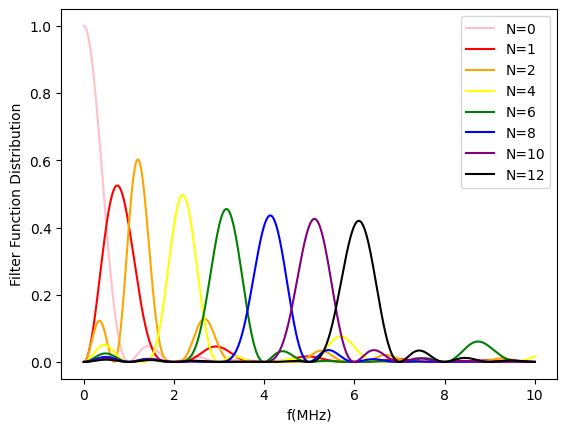

In [141]:
tau = 1

fig, ax = plt.subplots(1, 1)
ax.plot(omega_list, filter(omega_list, tau, 0), label = 'N=0', color='pink')
ax.plot(omega_list, filter(omega_list, tau, 1), label = 'N=1', color='red')
ax.plot(omega_list, filter(omega_list, tau, 2), label = 'N=2', color='orange')
ax.plot(omega_list, filter(omega_list, tau, 4), label = 'N=4', color='yellow')
ax.plot(omega_list, filter(omega_list, tau, 6), label = 'N=6', color='green')
ax.plot(omega_list, filter(omega_list, tau, 8), label = 'N=8', color='blue')
ax.plot(omega_list, filter(omega_list, tau, 10), label = 'N=10', color='purple')
ax.plot(omega_list, filter(omega_list, tau, 12), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('f(MHz)')
ax.set_ylabel('Filter Function Distribution')

<ipython-input-140-4b47b7f66497>:6: RuntimeWarning: invalid value encountered in divide
  f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
<ipython-input-140-4b47b7f66497>:10: RuntimeWarning: invalid value encountered in divide
  f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
<ipython-input-140-4b47b7f66497>:14: RuntimeWarning: invalid value encountered in divide
  f = (4*np.sin(2*np.pi*tau*omega_list/(4*N))*np.sin(2*np.pi*tau*omega_list/2)*np.cos(3*2*np.pi*tau*omega_list/(4*N))/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2


Text(0, 0.5, 'Filter Function Distribution')

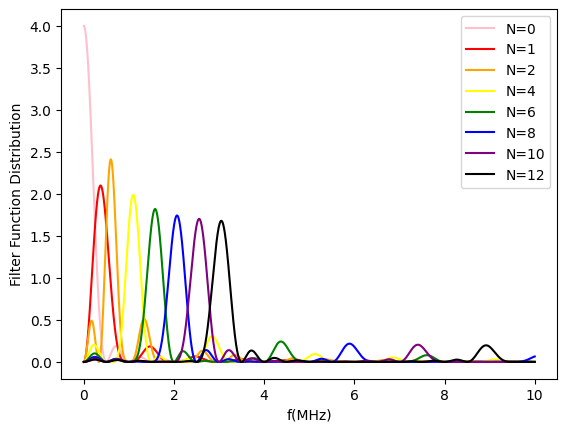

In [142]:
tau = 2

fig, ax = plt.subplots(1, 1)
ax.plot(omega_list, filter(omega_list, tau, 0), label = 'N=0', color='pink')
ax.plot(omega_list, filter(omega_list, tau, 1), label = 'N=1', color='red')
ax.plot(omega_list, filter(omega_list, tau, 2), label = 'N=2', color='orange')
ax.plot(omega_list, filter(omega_list, tau, 4), label = 'N=4', color='yellow')
ax.plot(omega_list, filter(omega_list, tau, 6), label = 'N=6', color='green')
ax.plot(omega_list, filter(omega_list, tau, 8), label = 'N=8', color='blue')
ax.plot(omega_list, filter(omega_list, tau, 10), label = 'N=10', color='purple')
ax.plot(omega_list, filter(omega_list, tau, 12), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('f(MHz)')
ax.set_ylabel('Filter Function Distribution')

### 4) White Noise Dephasing Calculation

$$ \chi_{N}(t)=\Gamma_\phi t $$

In [147]:
def chi_white(tau, N):
  freq_list = np.linspace(-100,100,10000)
  func = filter(freq_list, tau, N)
  A = 0
  for i in range(10000):
    A = A + func[i]*0.01

  return A

Text(0, 0.5, 'chi_white(t)')

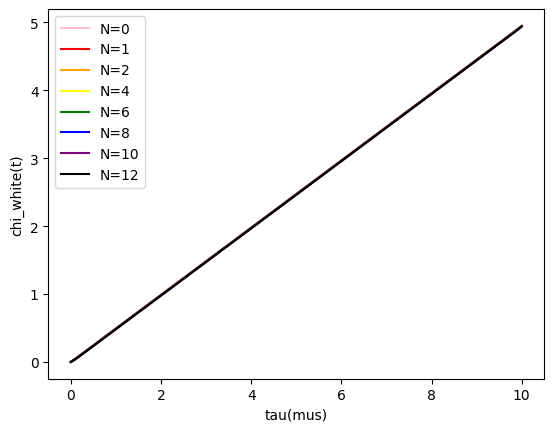

In [148]:
tau_list = np.linspace(0,10,100)

fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_white(0.1*tau, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_white(0.1*tau, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_white(0.1*tau, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_white(0.1*tau, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_white(0.1*tau, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_white(0.1*tau, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_white(0.1*tau, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_white(0.1*tau, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'off-diagonal term')

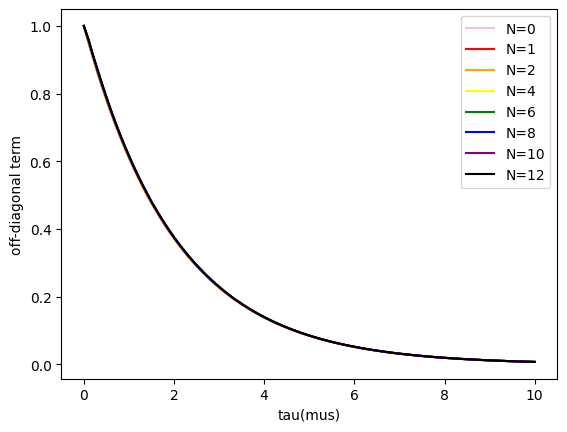

In [149]:
tau_list = np.linspace(0,10,100)

fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_white(0.1*tau, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('off-diagonal term')

### 5) Pink Noise Dephasing Calculation

$$ \chi_{N}(t)= C t^{2} $$

In [150]:
def chi_pink(tau, N):
  freq_list = np.linspace(0.001,100.001,10000)
  func = filter(freq_list, tau, N)/freq_list
  A = 0
  for i in range(10000):
    A = A + func[i]*0.01

  return 2*A

Text(0, 0.5, 'chi_pink(t)')

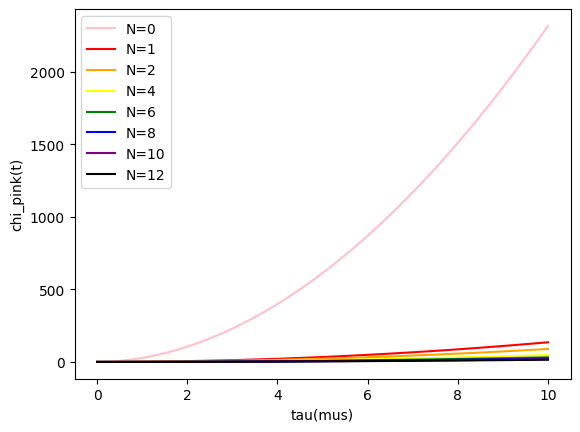

In [151]:
tau_list = np.linspace(0,10,100)

fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_pink(0.1*tau, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_pink(t)')

Text(0, 0.5, 'off-diagonal term')

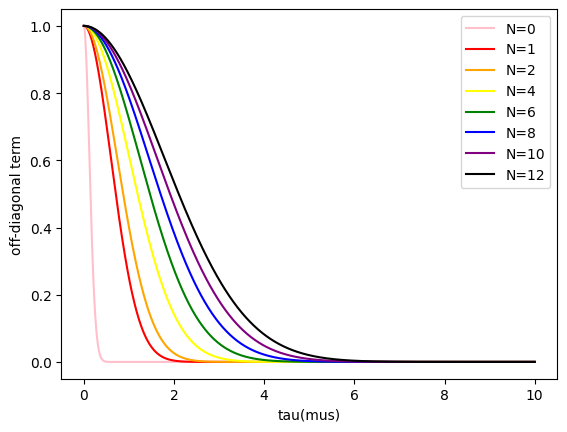

In [152]:
tau_list = np.linspace(0,10,1000)

fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 0) for tau in range(1000)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 1) for tau in range(1000)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 2) for tau in range(1000)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 4) for tau in range(1000)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 6) for tau in range(1000)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 8) for tau in range(1000)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 10) for tau in range(1000)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_pink(0.01*tau, 12) for tau in range(1000)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('off-diagonal term')

### 6) Ramsey Rotating Frame Changing A_noise

In [153]:
# Noise 1GHz Scale

omega_q = 2 * np.pi * 6.0
omega_rd = 2 * np.pi * 6.0

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

H0 = -0.5*omega_q*sz
op_list = [sx, sy, sz, sp, sm]

tlist = np.linspace(-3, 100-3, 100000)

result = mesolve(
  [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
  basis(2,0),
  tlist,
  args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 0, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.01},
  e_ops = op_list,
  options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

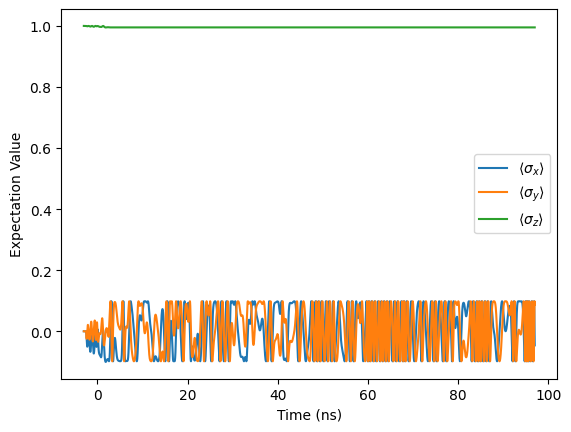

In [154]:
tlist = np.linspace(-3, 100-3, 100000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

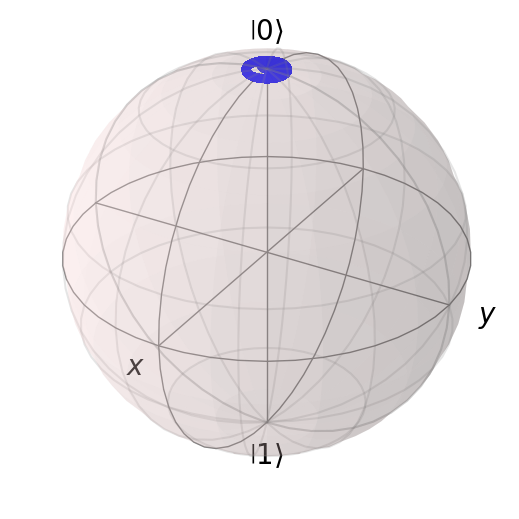

In [155]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result.expect, meth="s")
sphere.show()

In [156]:
# Noise 100MHz Scale

omega_q = 2 * np.pi * 6.0
omega_rd = 2 * np.pi * 6.0

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

H0 = -0.5*omega_q*sz
op_list = [sx, sy, sz, sp, sm]

tlist = np.linspace(-3, 100-3, 100000)

result = mesolve(
  [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
  basis(2,0),
  tlist,
  args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 0, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.001},
  e_ops = op_list,
  options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

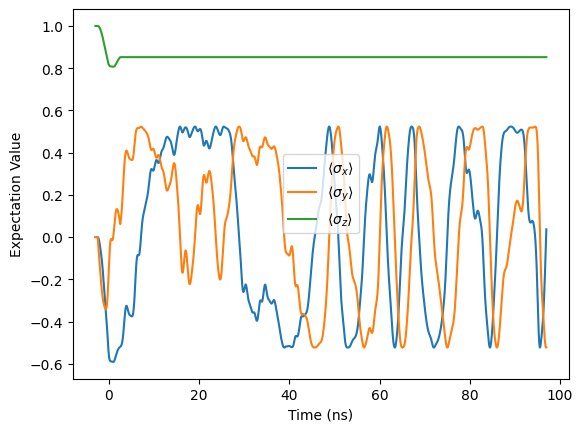

In [157]:
tlist = np.linspace(-3, 100-3, 100000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

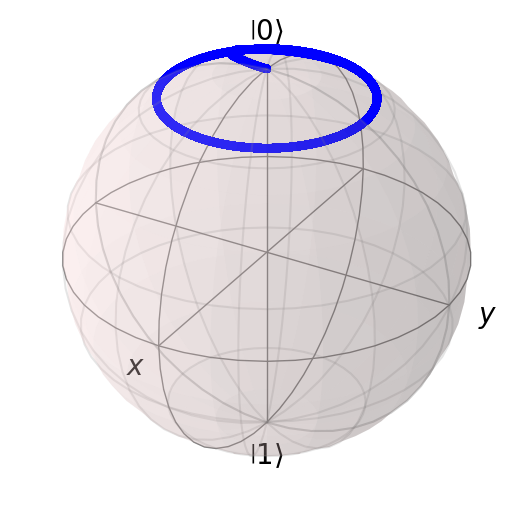

In [158]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result.expect, meth="s")
sphere.show()

In [159]:
# Noise 10MHz Scale

omega_q = 2 * np.pi * 6.0
omega_rd = 2 * np.pi * 6.0

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

H0 = -0.5*omega_q*sz
op_list = [sx, sy, sz, sp, sm]

tlist = np.linspace(-3, 100-3, 100000)

result = mesolve(
  [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
  basis(2,0),
  tlist,
  args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 0, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
  e_ops = op_list,
  options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

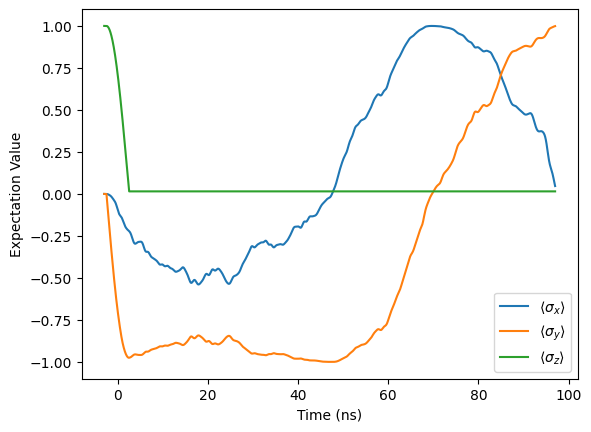

In [160]:
tlist = np.linspace(-3, 100-3, 100000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

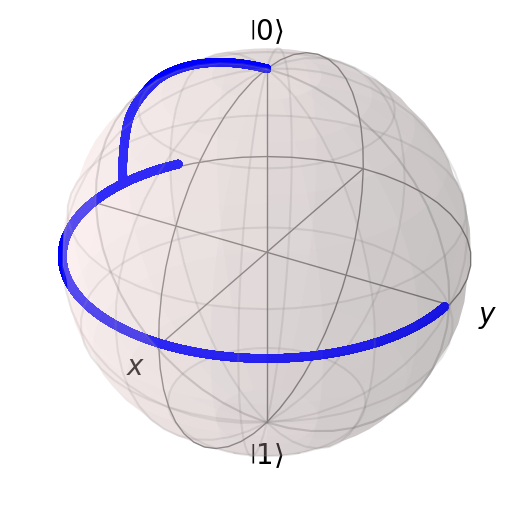

In [161]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result.expect, meth="s")
sphere.show()

In [162]:
# Noise 1MHz Scale

omega_q = 2 * np.pi * 6.0
omega_rd = 2 * np.pi * 6.0

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

H0 = -0.5*omega_q*sz
op_list = [sx, sy, sz, sp, sm]

tlist = np.linspace(-3, 100-3, 100000)

result = mesolve(
  [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
  basis(2,0),
  tlist,
  args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 0, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.00001},
  e_ops = op_list,
  options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

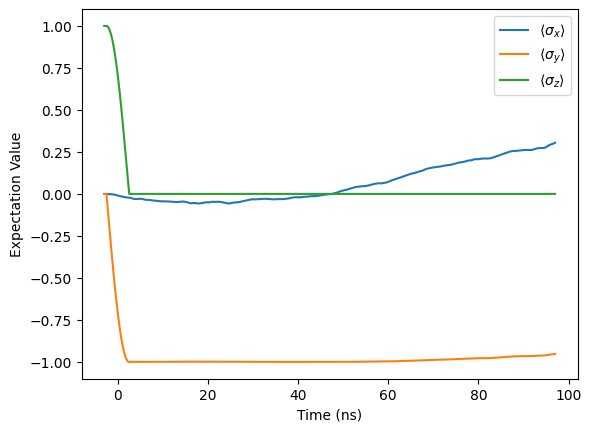

In [163]:
tlist = np.linspace(-3, 100-3, 100000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

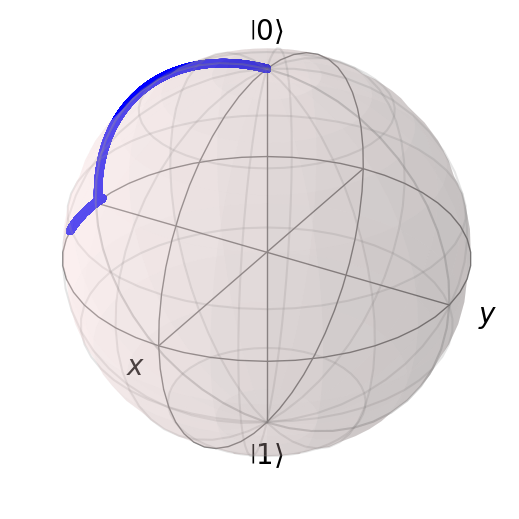

In [164]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result.expect, meth="s")
sphere.show()

In [165]:
# Noise 0.1MHz Scale

omega_q = 2 * np.pi * 6.0
omega_rd = 2 * np.pi * 6.0

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

H0 = -0.5*omega_q*sz
op_list = [sx, sy, sz, sp, sm]

tlist = np.linspace(-3, 100-3, 100000)

result = mesolve(
  [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
  basis(2,0),
  tlist,
  args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 0, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.000001},
  e_ops = op_list,
  options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

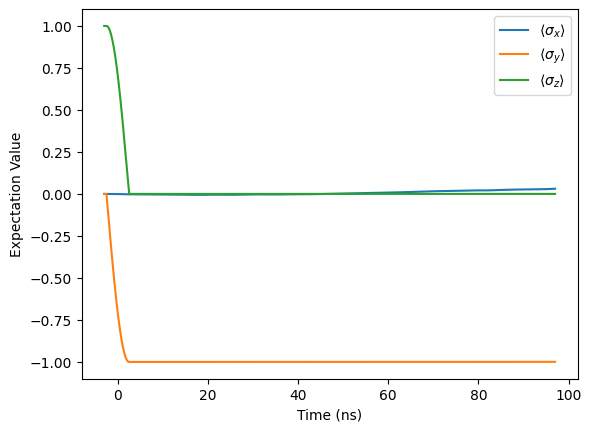

In [166]:
tlist = np.linspace(-3, 100-3, 100000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

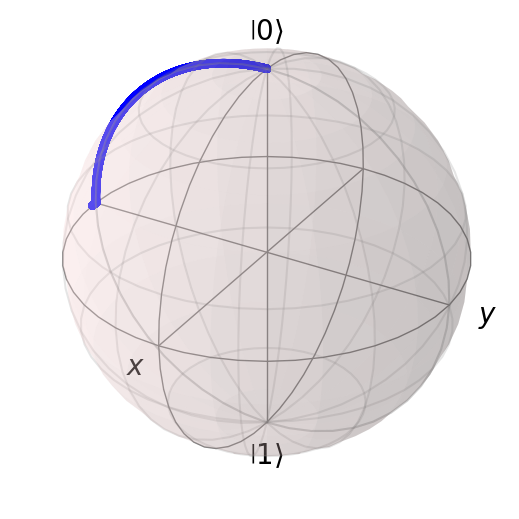

In [167]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result.expect, meth="s")
sphere.show()

### 7) Ramsey Rotating Frame Code (τ: 10~100ns)

In [ ]:
plus_10 = []
minus_10 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 10-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 10*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_10.append(plus[-1])
    minus_10.append(minus[-1])

In [ ]:
plus_20 = []
minus_20 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 20-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 20*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_20.append(plus[-1])
    minus_20.append(minus[-1])

In [ ]:
plus_30 = []
minus_30 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 30-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 30*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_30.append(plus[-1])
    minus_30.append(minus[-1])

In [ ]:
plus_40 = []
minus_40 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 40-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 40*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_40.append(plus[-1])
    minus_40.append(minus[-1])

In [ ]:
plus_50 = []
minus_50 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 50-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 50*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_50.append(plus[-1])
    minus_50.append(minus[-1])

In [ ]:
plus_60 = []
minus_60 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 60-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 60*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_60.append(plus[-1])
    minus_60.append(minus[-1])

In [ ]:
plus_70 = []
minus_70 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 70-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 70*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_70.append(plus[-1])
    minus_70.append(minus[-1])

In [ ]:
plus_80 = []
minus_80 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 80-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 80*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_80.append(plus[-1])
    minus_80.append(minus[-1])

In [ ]:
plus_90 = []
minus_90 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 90-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 90*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_90.append(plus[-1])
    minus_90.append(minus[-1])

In [ ]:
plus_100 = []
minus_100 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 100-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 100*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_100.append(plus[-1])
    minus_100.append(minus[-1])

In [ ]:
plus_10 = [(-0.1773655860941725+0.4674222540859098j),
 (-0.057526257277156295+0.49667962753037287j),
 (0.020536658925440904+0.49957756534739456j),
 (0.02904457698567968+0.49915457943215324j),
 (0.0968802117759095+0.4905239840780781j),
 (0.2219270301814483+0.447995884420359j),
 (0.30357120084620254+0.39724602835490386j),
 (0.19811294801619095+0.4590641644679693j),
 (0.2340698350276748+0.44182601876648225j),
 (0.22948163391798837+0.44422741743184097j),
 (0.26935168645514235+0.4211668627023259j),
 (0.2564708550533734+0.4291788569285821j),
 (0.06451696292901435+0.4958160095989104j),
 (-0.17181656065087036+0.46955194616436013j),
 (-0.15430677230837173+0.47556879600337487j),
 (-0.20143155163146179+0.45762222117432955j),
 (-0.13793263371099865+0.48059172972601033j),
 (-0.15512438924648514+0.4753246609822031j),
 (0.07870588875731535+0.49376645718211787j),
 (0.01738449256167037+0.4996974879061599j)]


plus_20 = [(-0.25589246447581526+0.42948941844720817j),
 (0.11031252099178204+0.4876788347478598j),
 (0.3656215296816312+0.3410578417839102j),
 (0.4732844574605335+0.16112636359286545j),
 (0.42948629650470393+0.25600867070704286j),
 (0.4779976972620599+0.14645838648358459j),
 (-0.13527126127256053+0.48134980982027065j),
 (-0.37426617782926364+0.3315133281433525j),
 (-0.33303473772157643+0.37293657062144125j),
 (0.12005496519357907+0.48537278094112857j),
 (-0.01239044735507793+0.49984645289271795j),
 (0.2090537800659662+0.4541987607772935j),
 (0.4526389862891187+0.21218027780813942j),
 (0.4996127691279972+0.01881607051817727j),
 (0.4107320146512142+0.2851265955226836j),
 (0.3575958004852727+0.3494341878407466j),
 (0.1493851411358863+0.4771620255976668j),
 (0.4773062215774506-0.1489095838213653j),
 (0.498464748151715+0.03731352321397524j),
 (0.4983740315977371+0.03979625320161534j)]


plus_30 = [(-0.23145709539591344+0.4431362386762549j),
 (0.4099906814492375+0.28619315614904156j),
 (0.48066401291736216-0.13755722385397987j),
 (0.46487944599987774-0.18408400102974184j),
 (-0.36689023586006675+0.33968736813011446j),
 (-0.4708778482373108+0.16812739110336947j),
 (0.08002347180183339+0.49355463232920344j),
 (0.2699469128986556+0.4208662949701703j),
 (0.4862936199674007-0.11584920733651241j),
 (0.47071310068055205-0.16842607456925549j),
 (0.34885170964031564+0.35816405906811893j),
 (0.40615386425052363-0.2916114977567137j),
 (0.39739226182295884-0.3032141056342479j),
 (0.49444613438879437+0.07374811159671907j),
 (0.49671842696450774+0.05697020218023244j),
 (-0.023216763589657123+0.4994606897803573j),
 (0.1391361134461059+0.4802507957320026j),
 (0.2843784629283676+0.4112456174500021j),
 (-0.386374600636781+0.3173556627378521j),
 (0.09428921383092413+0.4910282816861448j)]


plus_40 = []


plus_50 = []


plus_60 = []


plus_70 = []


plus_80 = []


plus_90 = []


plus_100 = []

In [ ]:
off_diagonal_ramsey = []

sum_plus_10 = 0
sum_plus_20 = 0
sum_plus_30 = 0
sum_plus_40 = 0
sum_plus_50 = 0
sum_plus_60 = 0
sum_plus_70 = 0
sum_plus_80 = 0
sum_plus_90 = 0
sum_plus_100 = 0

for k in range(20):
    sum_plus_10 = sum_plus_10 + plus_10[k]
    sum_plus_20 = sum_plus_20 + plus_20[k]
    sum_plus_30 = sum_plus_30 + plus_30[k]
    sum_plus_40 = sum_plus_40 + plus_40[k]
    sum_plus_50 = sum_plus_50 + plus_50[k]
    sum_plus_60 = sum_plus_60 + plus_60[k]
    sum_plus_70 = sum_plus_70 + plus_70[k]
    sum_plus_80 = sum_plus_80 + plus_80[k]
    sum_plus_90 = sum_plus_90 + plus_90[k]
    sum_plus_100 = sum_plus_100 + plus_100[k]

off_diagonal_ramsey.append(np.abs(sum_plus_10/20))
off_diagonal_ramsey.append(np.abs(sum_plus_20/20))
off_diagonal_ramsey.append(np.abs(sum_plus_30/20))
off_diagonal_ramsey.append(np.abs(sum_plus_40/20))
off_diagonal_ramsey.append(np.abs(sum_plus_50/20))
off_diagonal_ramsey.append(np.abs(sum_plus_60/20))
off_diagonal_ramsey.append(np.abs(sum_plus_70/20))
off_diagonal_ramsey.append(np.abs(sum_plus_80/20))
off_diagonal_ramsey.append(np.abs(sum_plus_90/20))
off_diagonal_ramsey.append(np.abs(sum_plus_100/20))

### 8) Spin Echo Rotating Frame Code (τ: 10~100ns)

In [ ]:
plus_10 = []
minus_10 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-2.5, 10-2.5, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 10*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_10.append(plus[-1])
    minus_10.append(minus[-1])

In [ ]:
plus_20 = []
minus_20 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 20-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 20, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 20*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_20.append(plus[-1])
    minus_20.append(minus[-1])

In [ ]:
plus_30 = []
minus_30 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 30-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 30, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 30*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_30.append(plus[-1])
    minus_30.append(minus[-1])

In [ ]:
plus_40 = []
minus_40 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 40-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 40, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 40*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_40.append(plus[-1])
    minus_40.append(minus[-1])

In [ ]:
plus_50 = []
minus_50 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 50-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 50, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 50*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_50.append(plus[-1])
    minus_50.append(minus[-1])

In [ ]:
plus_60 = []
minus_60 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 60-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 60, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 60*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_60.append(plus[-1])
    minus_60.append(minus[-1])

In [ ]:
plus_70 = []
minus_70 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 70-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 70, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 70*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_70.append(plus[-1])
    minus_70.append(minus[-1])

In [ ]:
plus_80 = []
minus_80 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 80-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 80, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 80*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_80.append(plus[-1])
    minus_80.append(minus[-1])

In [ ]:
plus_90 = []
minus_90 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 90-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 90, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 90*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_90.append(plus[-1])
    minus_90.append(minus[-1])

In [ ]:
plus_100 = []
minus_100 = []

for k in range(20):

    omega_q = 2 * np.pi * 6.0
    omega_rd = 2 * np.pi * 6.0

    sz = sigmaz()
    sx = sigmax()
    sy = sigmay()
    sp = basis(2,1)*basis(2,0).dag()
    sm = basis(2,0)*basis(2,1).dag()

    H0 = -0.5*omega_q*sz
    op_list = [sx, sy, sz, sp, sm]

    tlist = np.linspace(-3, 100-3, 100000)

    result = mesolve(
      [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
      basis(2,0),
      tlist,
      args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 1, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 100*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[3]
    minus = result.expect[4]

    plus_100.append(plus[-1])
    minus_100.append(minus[-1])

In [ ]:
plus_10 = [(-0.1773655860941725+0.4674222540859098j),
 (-0.057526257277156295+0.49667962753037287j),
 (0.020536658925440904+0.49957756534739456j),
 (0.02904457698567968+0.49915457943215324j),
 (0.0968802117759095+0.4905239840780781j),
 (0.2219270301814483+0.447995884420359j),
 (0.30357120084620254+0.39724602835490386j),
 (0.19811294801619095+0.4590641644679693j),
 (0.2340698350276748+0.44182601876648225j),
 (0.22948163391798837+0.44422741743184097j),
 (0.26935168645514235+0.4211668627023259j),
 (0.2564708550533734+0.4291788569285821j),
 (0.06451696292901435+0.4958160095989104j),
 (-0.17181656065087036+0.46955194616436013j),
 (-0.15430677230837173+0.47556879600337487j),
 (-0.20143155163146179+0.45762222117432955j),
 (-0.13793263371099865+0.48059172972601033j),
 (-0.15512438924648514+0.4753246609822031j),
 (0.07870588875731535+0.49376645718211787j),
 (0.01738449256167037+0.4996974879061599j)]


plus_20 = [(-0.25589246447581526+0.42948941844720817j),
 (0.11031252099178204+0.4876788347478598j),
 (0.3656215296816312+0.3410578417839102j),
 (0.4732844574605335+0.16112636359286545j),
 (0.42948629650470393+0.25600867070704286j),
 (0.4779976972620599+0.14645838648358459j),
 (-0.13527126127256053+0.48134980982027065j),
 (-0.37426617782926364+0.3315133281433525j),
 (-0.33303473772157643+0.37293657062144125j),
 (0.12005496519357907+0.48537278094112857j),
 (-0.01239044735507793+0.49984645289271795j),
 (0.2090537800659662+0.4541987607772935j),
 (0.4526389862891187+0.21218027780813942j),
 (0.4996127691279972+0.01881607051817727j),
 (0.4107320146512142+0.2851265955226836j),
 (0.3575958004852727+0.3494341878407466j),
 (0.1493851411358863+0.4771620255976668j),
 (0.4773062215774506-0.1489095838213653j),
 (0.498464748151715+0.03731352321397524j),
 (0.4983740315977371+0.03979625320161534j)]


plus_30 = [(-0.23145709539591344+0.4431362386762549j),
 (0.4099906814492375+0.28619315614904156j),
 (0.48066401291736216-0.13755722385397987j),
 (0.46487944599987774-0.18408400102974184j),
 (-0.36689023586006675+0.33968736813011446j),
 (-0.4708778482373108+0.16812739110336947j),
 (0.08002347180183339+0.49355463232920344j),
 (0.2699469128986556+0.4208662949701703j),
 (0.4862936199674007-0.11584920733651241j),
 (0.47071310068055205-0.16842607456925549j),
 (0.34885170964031564+0.35816405906811893j),
 (0.40615386425052363-0.2916114977567137j),
 (0.39739226182295884-0.3032141056342479j),
 (0.49444613438879437+0.07374811159671907j),
 (0.49671842696450774+0.05697020218023244j),
 (-0.023216763589657123+0.4994606897803573j),
 (0.1391361134461059+0.4802507957320026j),
 (0.2843784629283676+0.4112456174500021j),
 (-0.386374600636781+0.3173556627378521j),
 (0.09428921383092413+0.4910282816861448j)]


plus_40 = []


plus_50 = []


plus_60 = []


plus_70 = []


plus_80 = []


plus_90 = []


plus_100 = []

In [ ]:
off_diagonal_spinecho = []

sum_plus_10 = 0
sum_plus_20 = 0
sum_plus_30 = 0
sum_plus_40 = 0
sum_plus_50 = 0
sum_plus_60 = 0
sum_plus_70 = 0
sum_plus_80 = 0
sum_plus_90 = 0
sum_plus_100 = 0

for k in range(20):
    sum_plus_10 = sum_plus_10 + plus_10[k]
    sum_plus_20 = sum_plus_20 + plus_20[k]
    sum_plus_30 = sum_plus_30 + plus_30[k]
    sum_plus_40 = sum_plus_40 + plus_40[k]
    sum_plus_50 = sum_plus_50 + plus_50[k]
    sum_plus_60 = sum_plus_60 + plus_60[k]
    sum_plus_70 = sum_plus_70 + plus_70[k]
    sum_plus_80 = sum_plus_80 + plus_80[k]
    sum_plus_90 = sum_plus_90 + plus_90[k]
    sum_plus_100 = sum_plus_100 + plus_100[k]

off_diagonal_spinecho.append(np.abs(sum_plus_10/20))
off_diagonal_spinecho.append(np.abs(sum_plus_20/20))
off_diagonal_spinecho.append(np.abs(sum_plus_30/20))
off_diagonal_spinecho.append(np.abs(sum_plus_40/20))
off_diagonal_spinecho.append(np.abs(sum_plus_50/20))
off_diagonal_spinecho.append(np.abs(sum_plus_60/20))
off_diagonal_spinecho.append(np.abs(sum_plus_70/20))
off_diagonal_spinecho.append(np.abs(sum_plus_80/20))
off_diagonal_spinecho.append(np.abs(sum_plus_90/20))
off_diagonal_spinecho.append(np.abs(sum_plus_100/20))

### 9) Ramsey, Spin Echo Dephasing Simulation